## Extending to five Component PR EOS

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rcParams
import numpy as np
import matplotlib.cm as cm # matplotlib's color map library
#rcParams['figure.figsize'] = 18.75, 18.75
from scipy import stats
import seaborn as sns
from scipy.interpolate import griddata
import seaborn as sns
import pr_z_v11 as pr_z
#import pr_z_v7_DefaultOmega as pr_z
R, mwAir, degF2R = 10.731577089016, 28.97, 459.67
from tabulate import tabulate as tabulate

import importlib
importlib.reload(pr_z)
import pyrestoolbox as rtb
importlib.reload(rtb)

import gerg2
importlib.reload(gerg2)

<module 'gerg2' from 'C:\\Users\\vinom\\OneDrive - Santos\\Work in progress\\Python\\0-ResEng\\Z-Factors\\Inerts4\\gerg2.py'>

In [2]:
hc_mw, degf = 16, 80
bips = pr_z.calc_bips(hc_mw, degf)
header = ['', 'CO2', 'H2S', 'N2', 'H2', 'HC_Gas']
rows = [[header[j+1]]+list(bips[j]) for j in range(5)]
print(tabulate(rows, header))

               CO2         H2S          N2         H2     HC_Gas
------  ----------  ----------  ----------  ---------  ---------
CO2      0           0.0567332  -0.205067   0.648344   0.0656872
H2S      0.0567332   0          -0.212124   0.65       0.0989223
N2      -0.205067   -0.212124    0          0.36917    0.0295766
H2       0.648344    0.65        0.36917    0          0.0783693
HC_Gas   0.0656872   0.0989223   0.0295766  0.0783693  0


In [3]:
degf, psia, sg, co2, h2s, n2, h2 = 60, 1500, 16.043/28.97, 0.0, 0.5, 0, 0
z = pr_z.peng_robinson_z(degf, psia, sg, co2=co2, h2s=h2s, n2=n2, h2 = h2)
vis = pr_z.lbc(z, degf, psia, sg, co2=co2, h2s=h2s, n2=n2, h2 = h2)
z, vis

(0.3695437067561813, 0.027498803463309664)

In [4]:
def Zplots(component, psat_coefics):
    rcParams['figure.figsize'] = 9, 9

    plt.plot(Zs, calc_Zs, 'o')
    plt.plot([min(Zs), max(Zs)], [min(Zs), max(Zs)], '--', c='k')
    plt.title(component+' Calculated vs GERG2008 Molar Density')
    plt.xlabel('GERG2008 Z-Factor')
    plt.ylabel('Calculated Z-Factor')
    plt.grid()
    plt.savefig('images\\'+component+'_1.png')
    plt.show()
    errs = np.abs(calc_Zs - Zs)/Zs
    print('Average Relative error:',np.mean(errs))
    print('95% of data better than error:', np.percentile(errs, 95))
    
    #errs = (calc_Zs - Zs)/Zs
    errs = (molar_densities - calc_molar_densities)/molar_densities
    plt.plot(molar_densities, errs, 'o')
    plt.title(component+' Relative Error in Calculated Molar Density')
    plt.xlabel('GERG2008 Molar Density (lb-mol/cuft)')
    plt.ylabel('(Calculated - GERG2008-Z)/GERG2008')
    plt.grid()
    plt.ylim(-0.1, 0.1)
    plt.savefig('images\\'+component+'_2.png')
    plt.show()
    
    #fig, ax = plt.subplots()
    #res = stats.probplot(errs, plot=ax)
    #ax.set_title('Normal Probability Plot of '+component+' Residuals')
    #ax.set_xlabel('Theoretical Quantiles')
    #ax.set_ylabel('Ordered Values')
    #plt.show()

    x = degfs
    y = psias
    z = errs
    
    tc, a0, a1, a2, a3 = psat_coefics
    tsat = np.arange(x[0], tc, 0.1)
    psat = a0*tsat**3+a1*tsat**2+a2*tsat+a3
    pc = a0*tc**3+a1*tc**2+a2*tc+a3

    # target grid to interpolate to
    yi = np.arange(15,15000,20)
    xi = np.arange(50, 300, 5)
    xi,yi = np.meshgrid(xi,yi)

    # interpolate
    zi = griddata((x,y), z, (xi,yi),method='linear')

    rcParams['figure.figsize'] = 15, 9
    fig, ax = plt.subplots()
    #c = ax.pcolormesh(xi, yi, zi, cmap='RdBu', vmin=zi.min(), vmax=zi.max())
    c = ax.pcolormesh(xi, yi, zi, cmap='RdBu', vmin=-0.05, vmax=0.05)
    levels = np.arange(-0.05, 0.06, 0.01)
    CS = ax.contour(xi, yi, zi, levels=levels, linewidths=0.5, colors='k')
    ax.clabel(CS, inline=True, fontsize=10)

    ax.set_title(component+' Molar Density Relative Error (Calc - GERG) / GERG')
    # set the limits of the plot to the limits of the data
    ax.axis([xi.min(), xi.max(), yi.min(), yi.max()])
    ax.set_ylabel('psia')
    ax.set_xlabel('degf')
    ax.set_ylim(0, 15000)
    ax.set_xlim(60, 300)
    
    plt.plot(tsat, psat, c='g')
    plt.plot([tc], [pc], 'o', c='g')
    
    #ax.set_ylim(0, 15)
    fig.colorbar(c, ax=ax)
    plt.grid()
    plt.savefig('images\\'+component+'_3.png')
    plt.show()
    rcParams['figure.figsize'] = 9, 9



def molar_plots(component):
    rcParams['figure.figsize'] = 9, 9
    
    plt.plot(molar_densities, calc_molar_densities, 'o')
    plt.plot([min(molar_densities), max(molar_densities)], [min(molar_densities), max(molar_densities)], '--', c='k')
    plt.title(component+' Calculated Molar Density vs GERG2008')
    plt.xlabel('GERG2008 Molar Density (lbmol/ft3)')
    plt.ylabel('Calculated Molar Density (lbmol/ft3)')
    plt.grid()
    #plt.savefig('co2.png')
    plt.show()
    errs = np.abs(calc_molar_densities - molar_densities)/molar_densities
    print('Average Relative absolute error:',np.mean(errs))
    print('95% of data better than error:', np.percentile(errs, 95))
    
    errs = (calc_molar_densities - molar_densities)/molar_densities
    plt.plot(molar_densities, errs, 'o')
    plt.title(component+' Relative Error in Calculated Molar Density')
    plt.xlabel('GERG2008 Molar Density (lbmol/ft3)')
    plt.ylabel('(Calculated - GERG2008)/GERG2008')
    plt.grid()
    plt.ylim(-0.1, 0.1)
    plt.savefig('images\\'+component+'_4.png')
    plt.show()

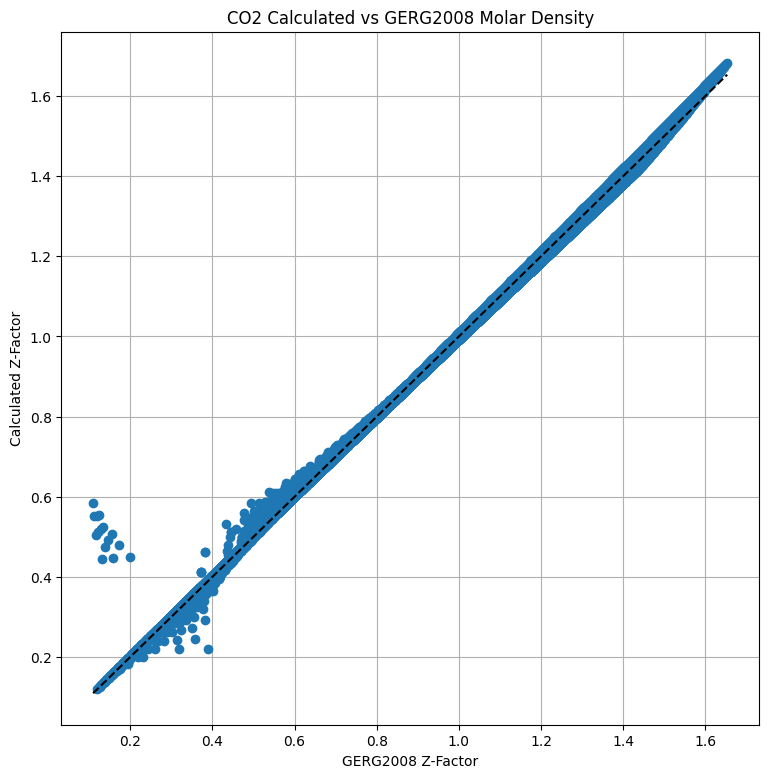

Average Relative error: 0.007612571824750346
95% of data better than error: 0.012229823902867788


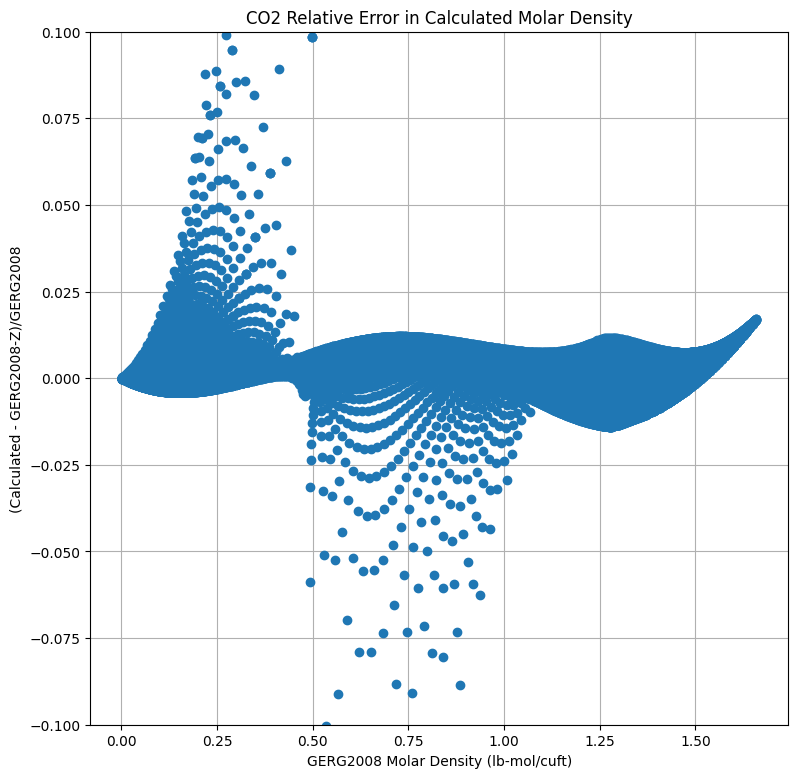

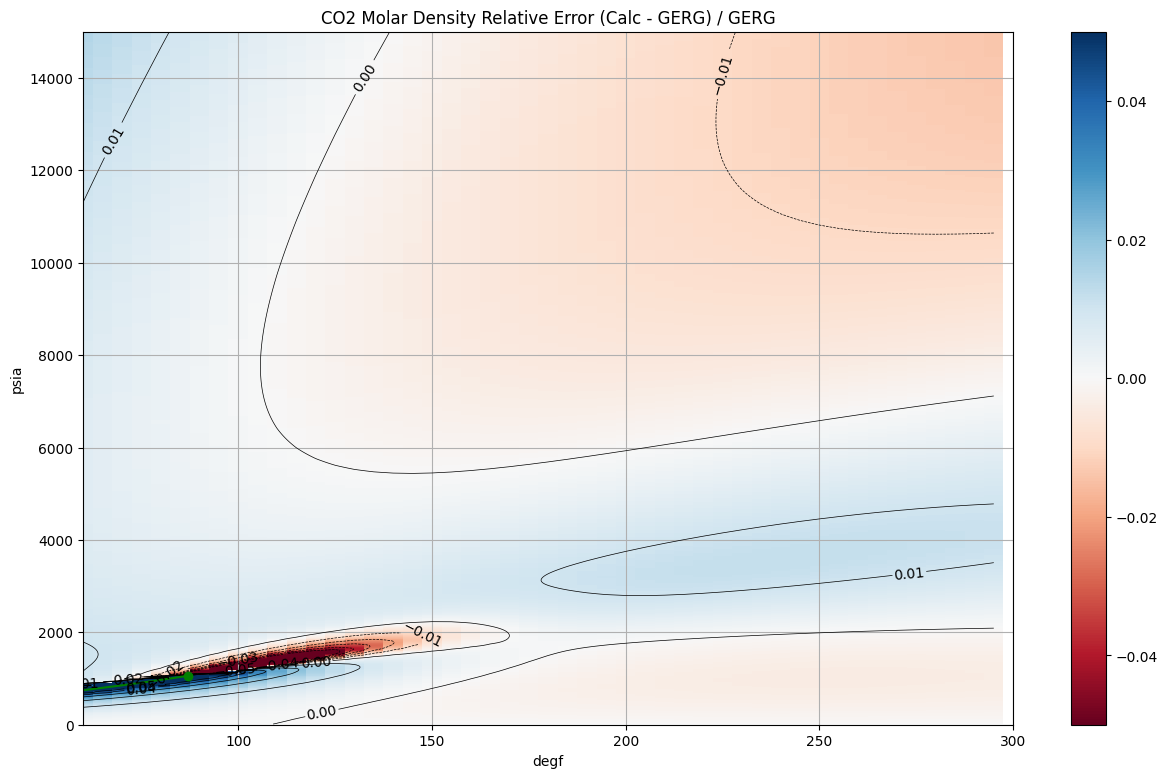

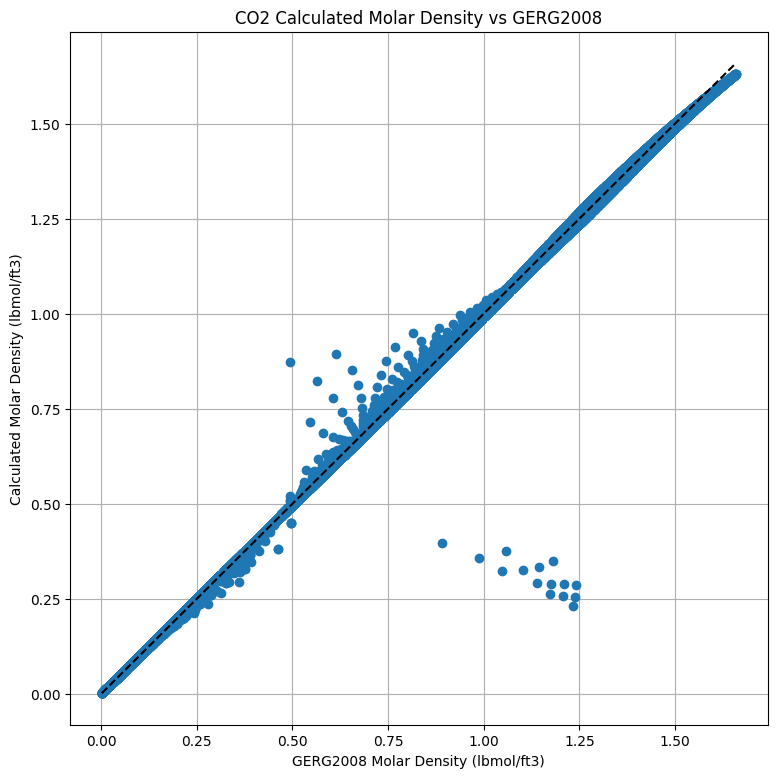

Average Relative absolute error: 0.006615471060517935
95% of data better than error: 0.012314773061740544


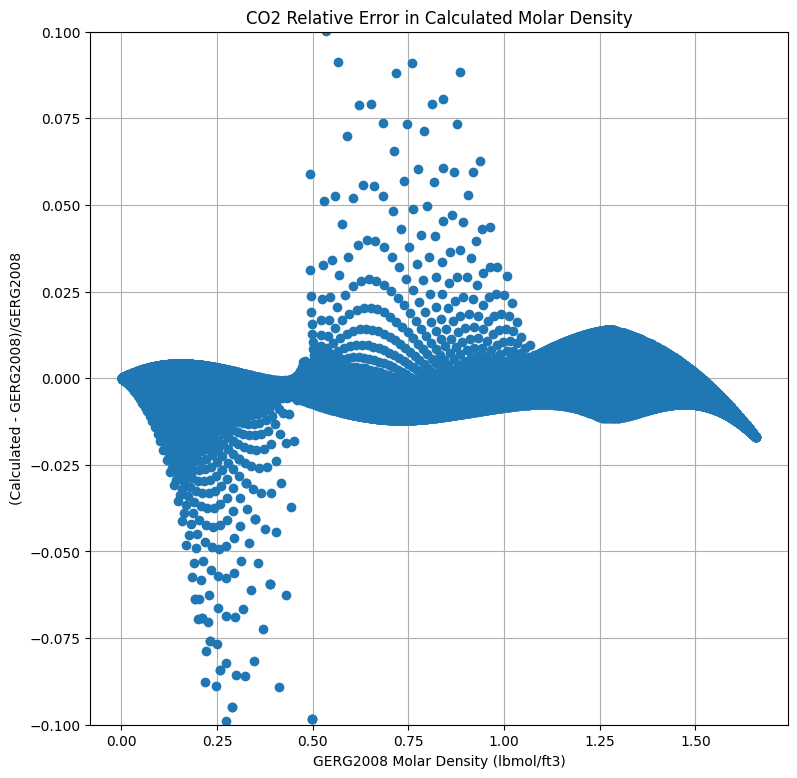

In [5]:
# Compare pure CO2
mwAir = 28.97
mwGas = 44.01
sg = mwGas/mwAir
co2, h2s, n2, h2 = 1.0, 0.0, 0.0, 0.0
df = pd.read_excel('Z-GERG_CO2.xlsx')#, sheet_name='CO2')
degfs = np.array(df['Temperature (F)'])
psias = np.array(df['Pressure (psia)'])
Zs = np.array(df['Z-Gerg'])
molar_densities = psias/(Zs*R*(degfs+degF2R)) # lb-mol/(cuft.lbm)
calc_Zs = []
for i in range(len(degfs)):
    calc_Zs.append(pr_z.peng_robinson_z(degfs[i], psias[i], sg, co2=co2, h2s=h2s, n2=n2, h2=h2))
calc_Zs = np.array(calc_Zs)
calc_molar_densities = psias/(calc_Zs*R*(degfs+degF2R))
errs = np.abs(calc_Zs - Zs)/Zs
Zplots('CO2', [87, 0.000199491, 0.016819666, 5.798738321, 296.0668442])
molar_plots('CO2')

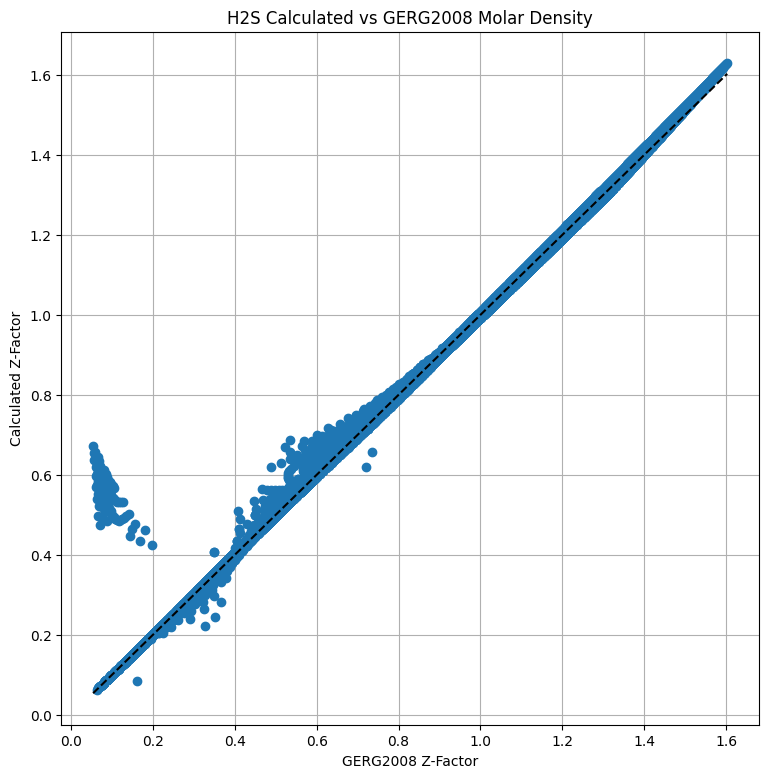

Average Relative error: 0.02102488332171363
95% of data better than error: 0.01247972745970201


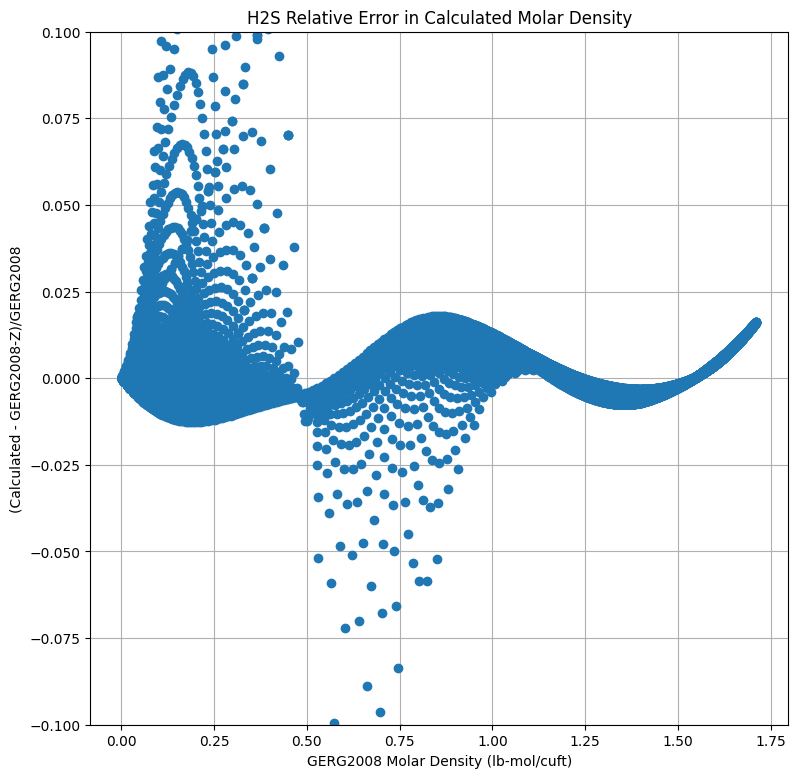

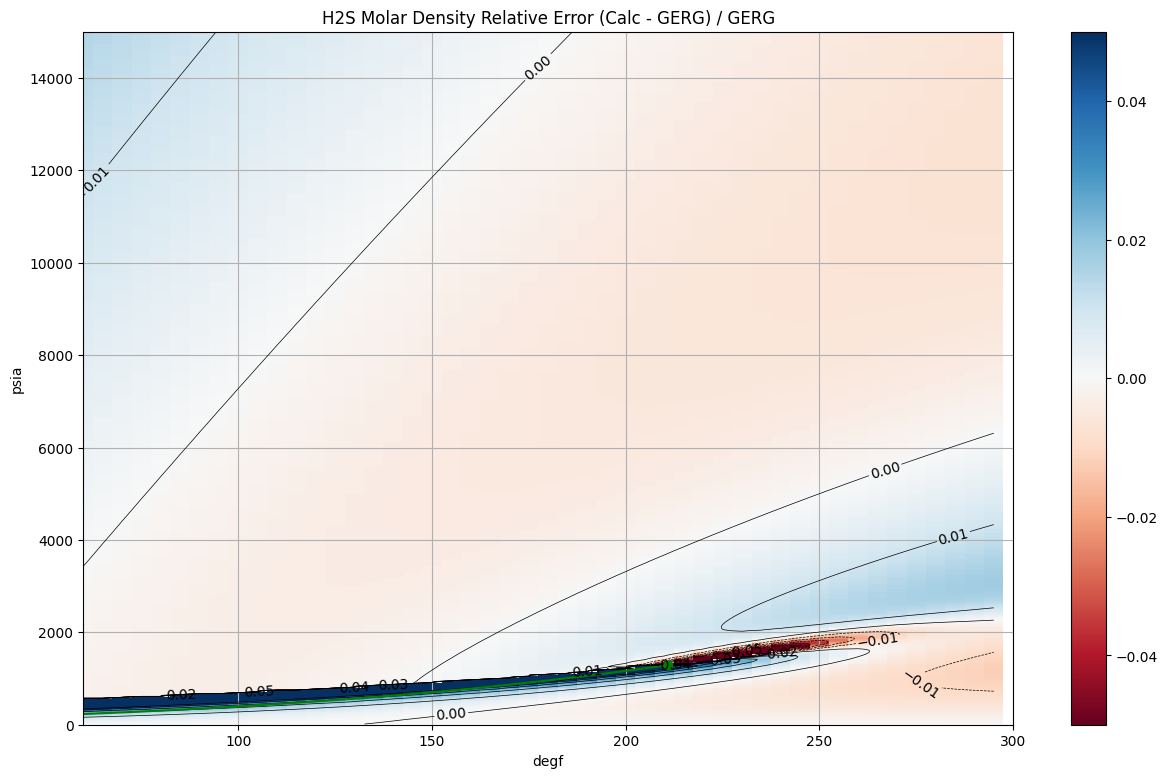

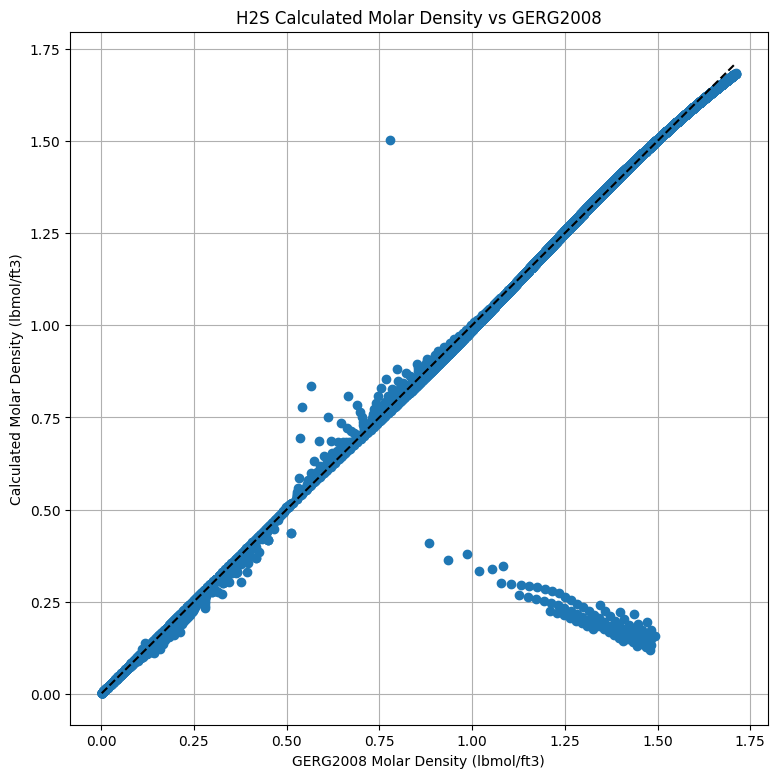

Average Relative absolute error: 0.007579705236356864
95% of data better than error: 0.012372681011451366


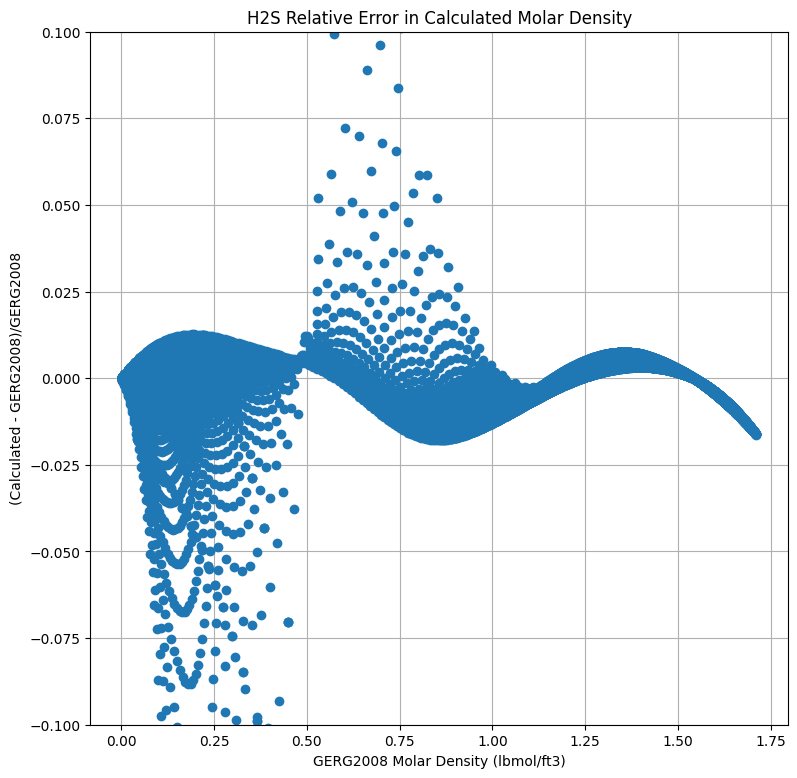

In [6]:
# Compare pure H2S
mwGas = 34.082
sg = mwGas/mwAir
co2, h2s, n2, h2 = 0.0, 1.0, 0.0, 0
df = pd.read_excel('Z-GERG_H2S.xlsx')#, sheet_name='H2S')
degfs = np.array(df['Temperature (F)'])
psias = np.array(df['Pressure (psia)'])
Zs = np.array(df['Z-Gerg'])
molar_densities = psias/(Zs*R*(degfs+degF2R)) # lb-mol/(cuft.lbm)
calc_Zs = []
for i in range(len(degfs)):
    calc_Zs.append(pr_z.peng_robinson_z(degfs[i], psias[i], sg, co2=co2, h2s=h2s, n2=n2, h2=h2))
calc_Zs = np.array(calc_Zs)
calc_molar_densities = psias/(calc_Zs*R*(degfs+degF2R))
errs = np.abs(calc_Zs - Zs)/Zs
Zplots('H2S', [211, 5.71085E-05, 0.004922, 2.219774185, 66.98795])
molar_plots('H2S')

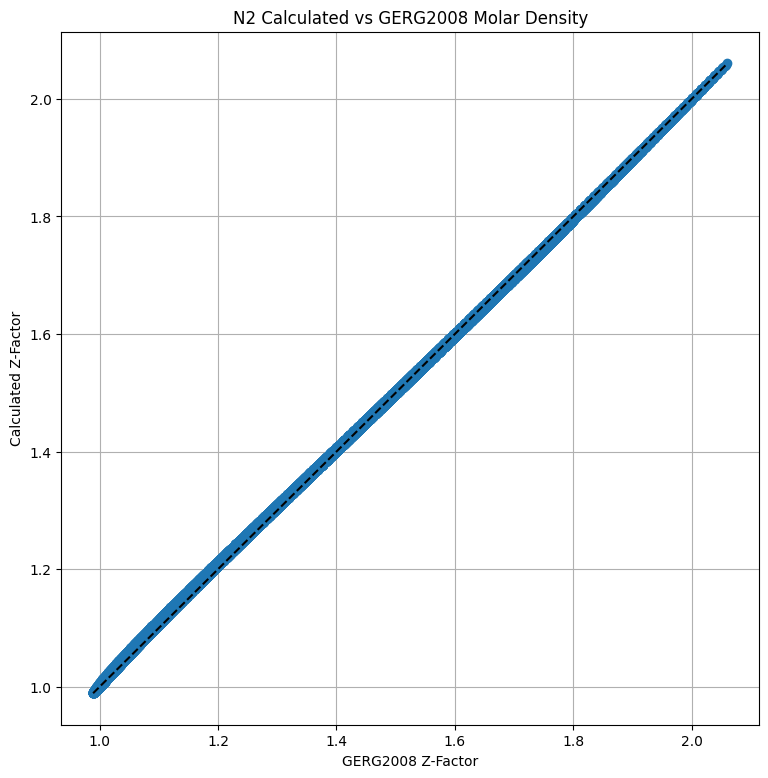

Average Relative error: 0.0037386414382105447
95% of data better than error: 0.009982630405129964


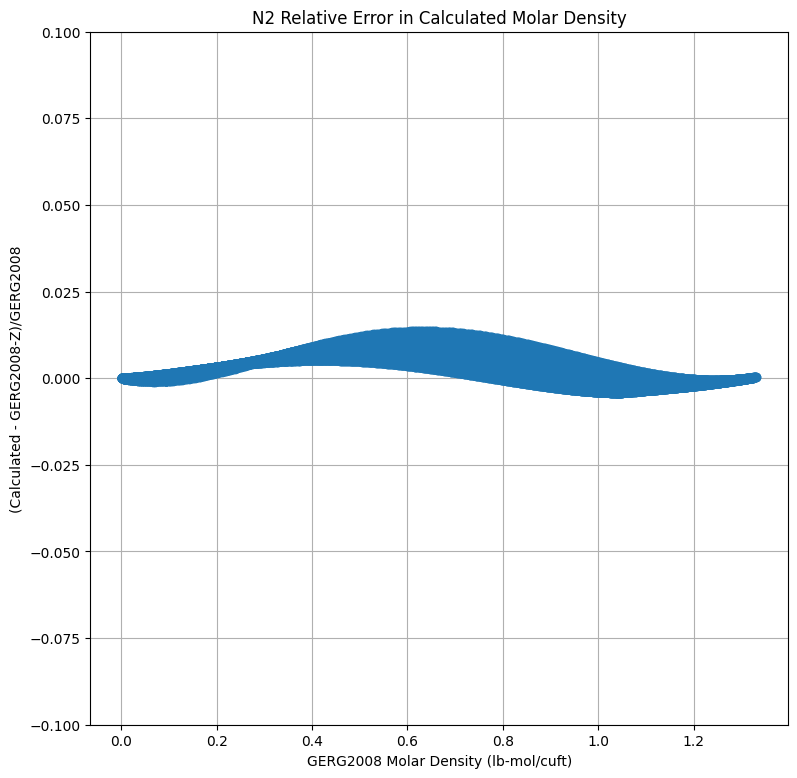

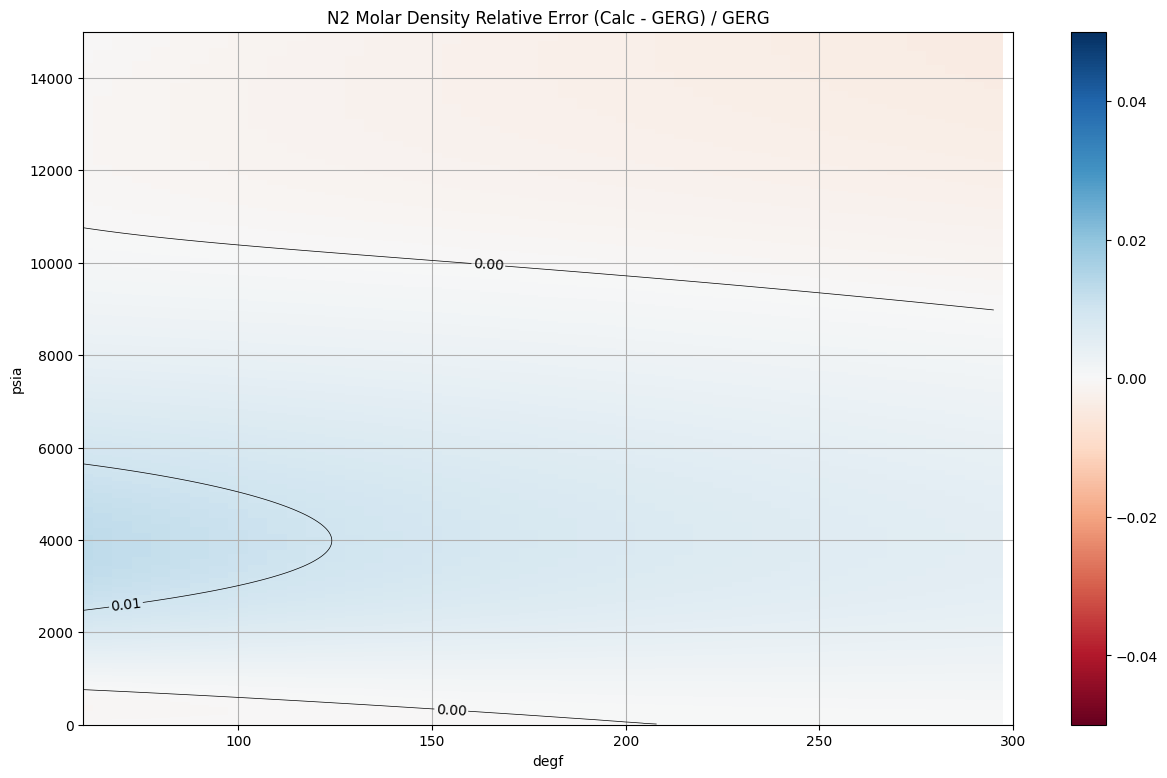

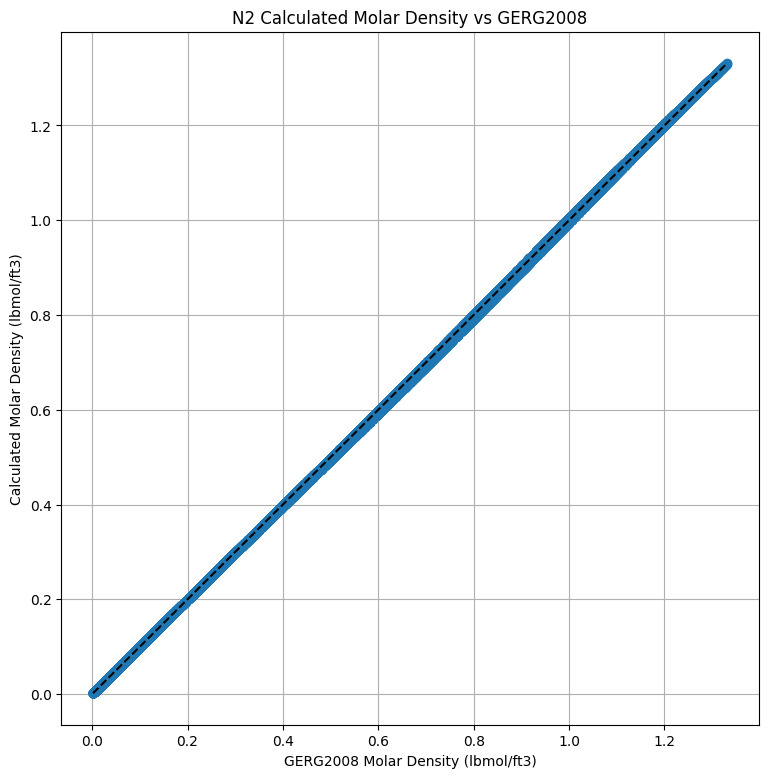

Average Relative absolute error: 0.003718683433260299
95% of data better than error: 0.00988396245957595


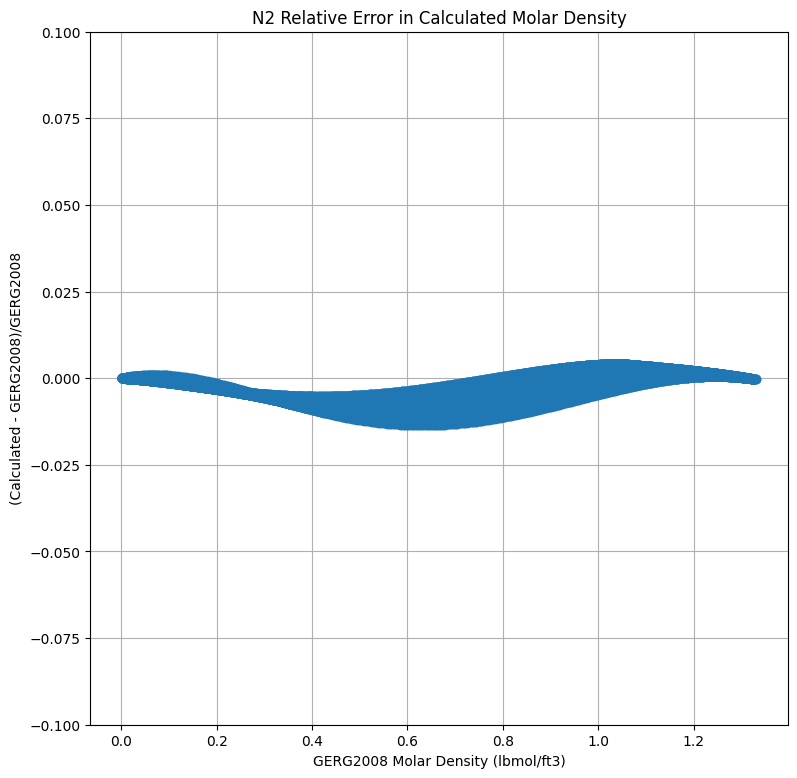

In [7]:
# Compare pure N2
mwGas = 28.014
sg = mwGas/mwAir
co2, h2s, n2, h2 = 0.0, 0.0, 1.0, 0
df = pd.read_excel('Z-GERG_N2.xlsx')#, sheet_name='N2')
degfs = np.array(df['Temperature (F)'])
psias = np.array(df['Pressure (psia)'])
Zs = np.array(df['Z-Gerg'])
molar_densities = psias/(Zs*R*(degfs+degF2R))
calc_Zs = []
for i in range(len(degfs)):
    calc_Zs.append(pr_z.peng_robinson_z(degfs[i], psias[i], sg, co2=co2, h2s=h2s, n2=n2, h2=h2))
calc_Zs = np.array(calc_Zs)
calc_molar_densities = psias/(calc_Zs*R*(degfs+degF2R))
errs = np.abs(calc_Zs - Zs)/Zs
Zplots('N2', [-233, 0.000323591, 0.333366681, 114.9031482, 13251.33895])
molar_plots('N2')

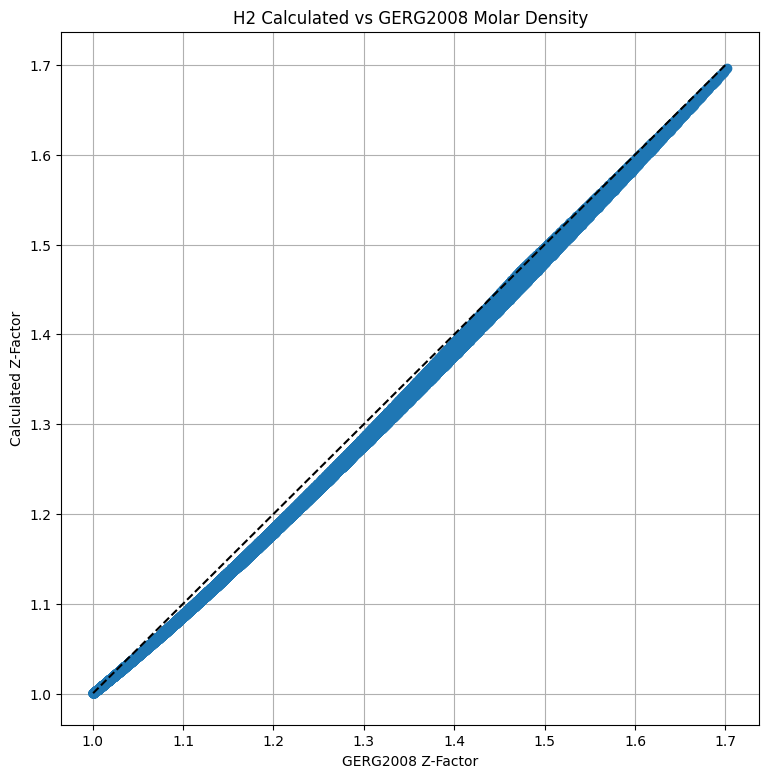

Average Relative error: 0.011016213913440492
95% of data better than error: 0.01750164100317078


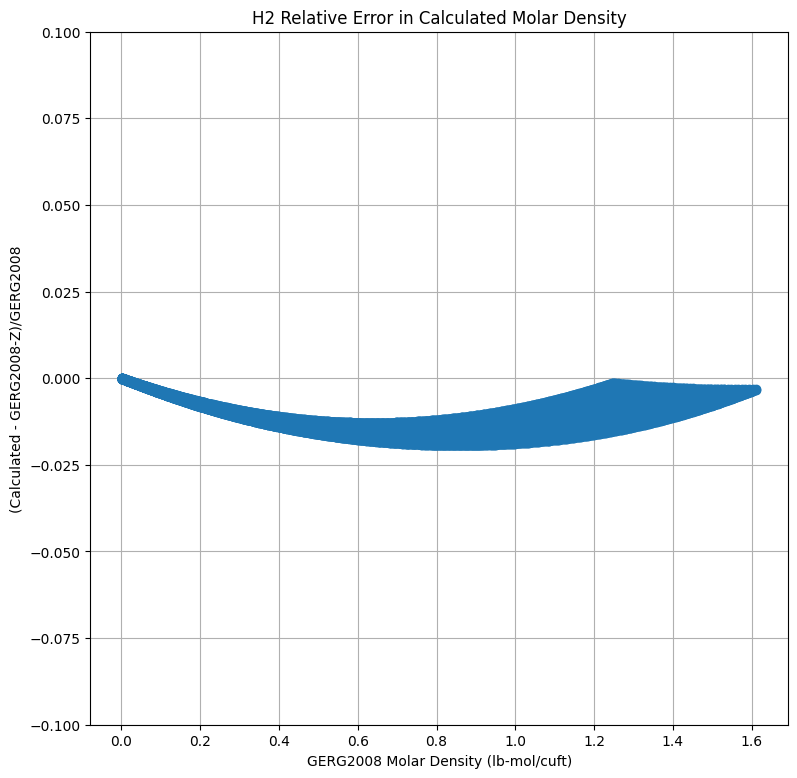

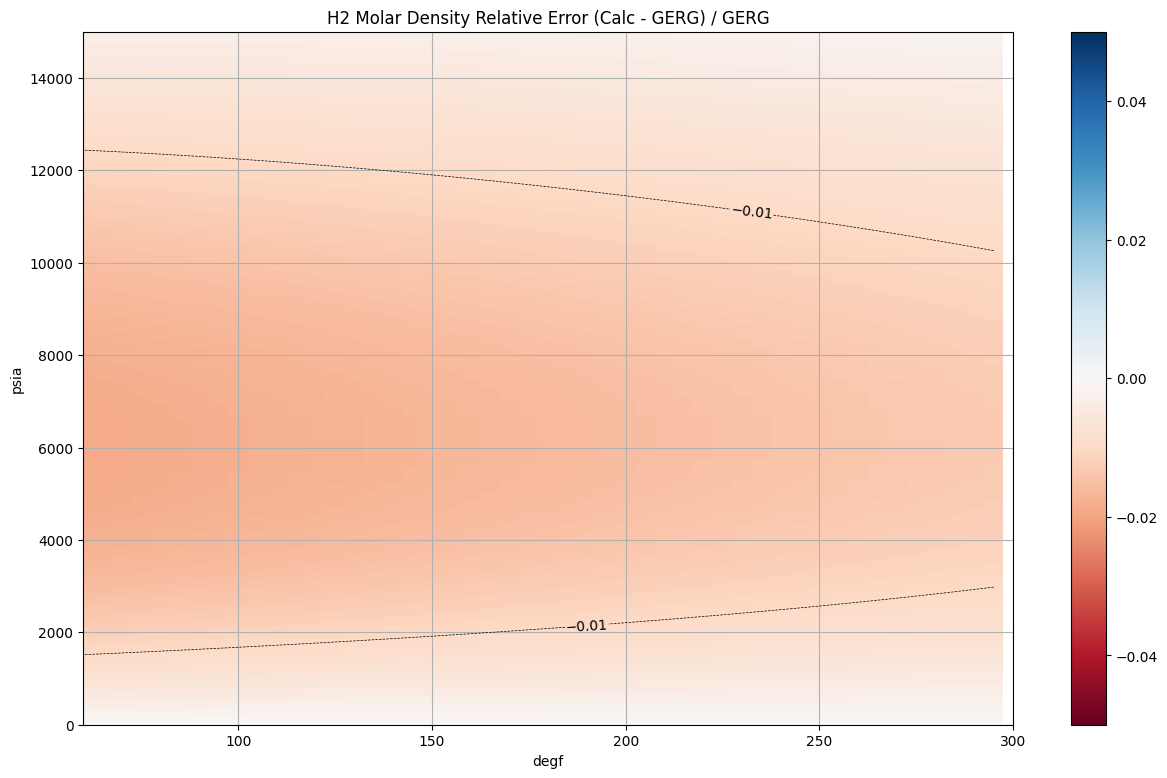

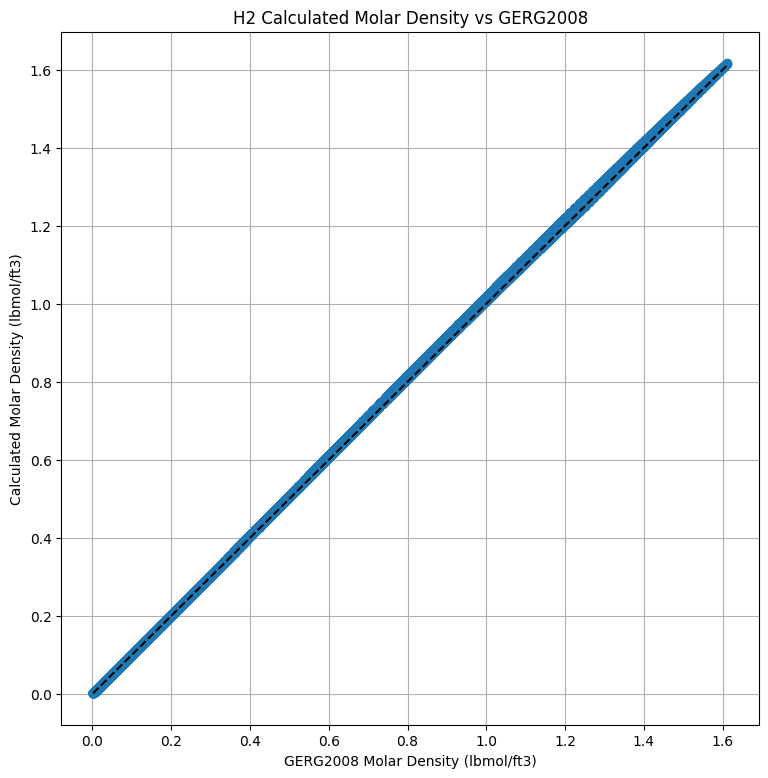

Average Relative absolute error: 0.011160105887585597
95% of data better than error: 0.017813404819364505


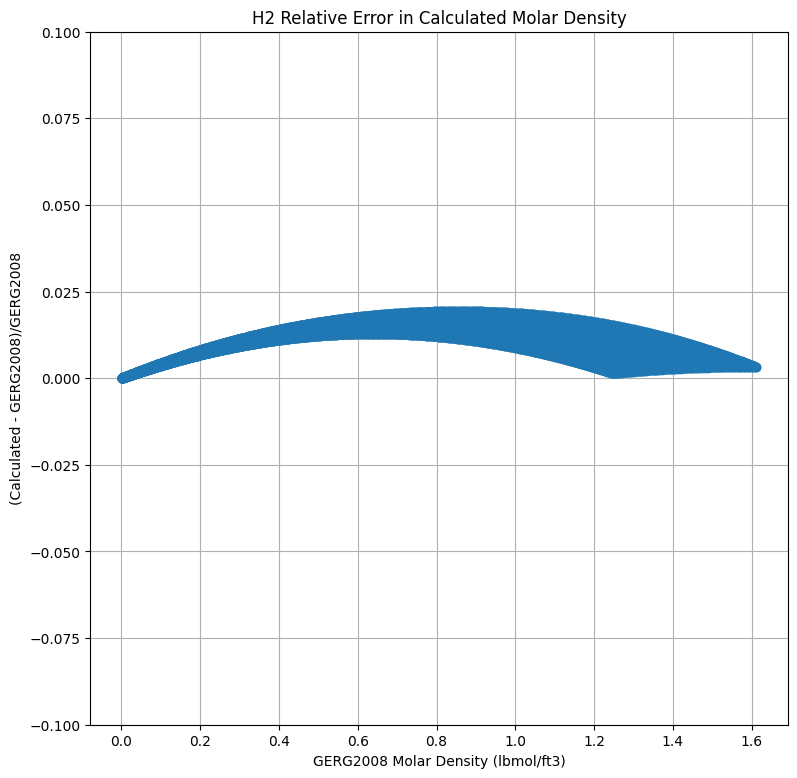

In [8]:
# Compare pure H2
mwGas = 2.016
sg = mwGas/mwAir
co2, h2s, n2, h2 = 0.0, 0.0, 0.0, 1.0
df = pd.read_excel('Z-GERG_H2.xlsx')#, sheet_name='H2')
degfs = np.array(df['Temperature (F)'])
psias = np.array(df['Pressure (psia)'])
Zs = np.array(df['Z-Gerg'])
molar_densities = psias/(Zs*R*(degfs+degF2R))
calc_Zs = []
for i in range(len(degfs)):
    calc_Zs.append(pr_z.peng_robinson_z(degfs[i], psias[i], sg, co2=co2, h2s=h2s, n2=n2, h2=h2))
calc_Zs = np.array(calc_Zs)
calc_molar_densities = psias/(calc_Zs*R*(degfs+degF2R))
errs = np.abs(calc_Zs - Zs)/Zs
Zplots('H2', [-233, 0.000323591, 0.333366681, 114.9031482, 13251.33895])
molar_plots('H2')

In [9]:
df = pd.read_excel('Wichert_data_export_v10.xlsx')


filtered = df[df['Source'] == 'GERG']

degfs = np.array(filtered['degf'])
psias = np.array(filtered['psia'])
sgs = np.array(filtered['sg'])
co2s = np.array(filtered['co2'])
h2ss = np.array(filtered['h2s'])
n2s = np.array(filtered['n2'])
Zs = np.array(filtered['Z'])

c1s = np.array(filtered['C1'])
c2s = np.array(filtered['C2'])
c3s = np.array(filtered['C3'])
ic4s = np.array(filtered['iC4'])
nc4s = np.array(filtered['nC4'])
ic5s = np.array(filtered['iC5'])
nc5s = np.array(filtered['nC5'])
c6s = np.array(filtered['C6'])
c7s = np.array(filtered['C7'])
c8s = np.array(filtered['C8'])
c9s = np.array(filtered['C9'])
c10s = np.array(filtered['C9'])
yis = [np.array([c1s[i], c2s[i], c3s[i], ic4s[i], nc4s[i], ic5s[i], nc5s[i], c6s[i], c7s[7], c8s[i], c9s[i], c10s[i]]) for i in range(len(c1s))]
       
GERG_Zs = []
       
for i in range(len(degfs)):
    GERG_Zs.append(gerg2.gerg_z2(psias[i], degfs[i], yis[i], co2=co2s[i], h2s=h2ss[i], n2=n2s[i], h2 = 0))
    print(psias[i], degfs[i], GERG_Zs[-1])

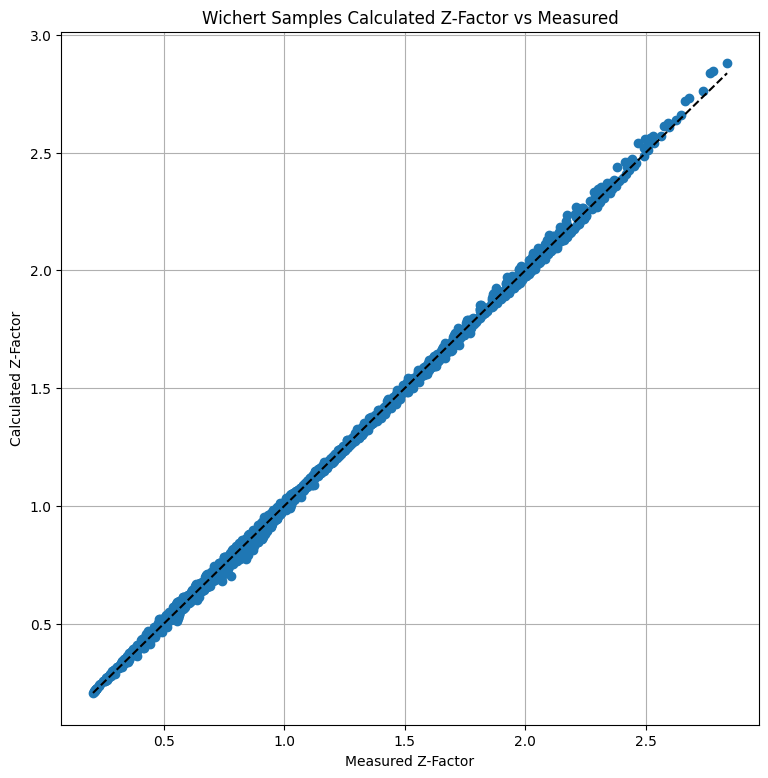

Average Relative error: 0.010624873690749187
99% of data better than error: 0.05117059169974097


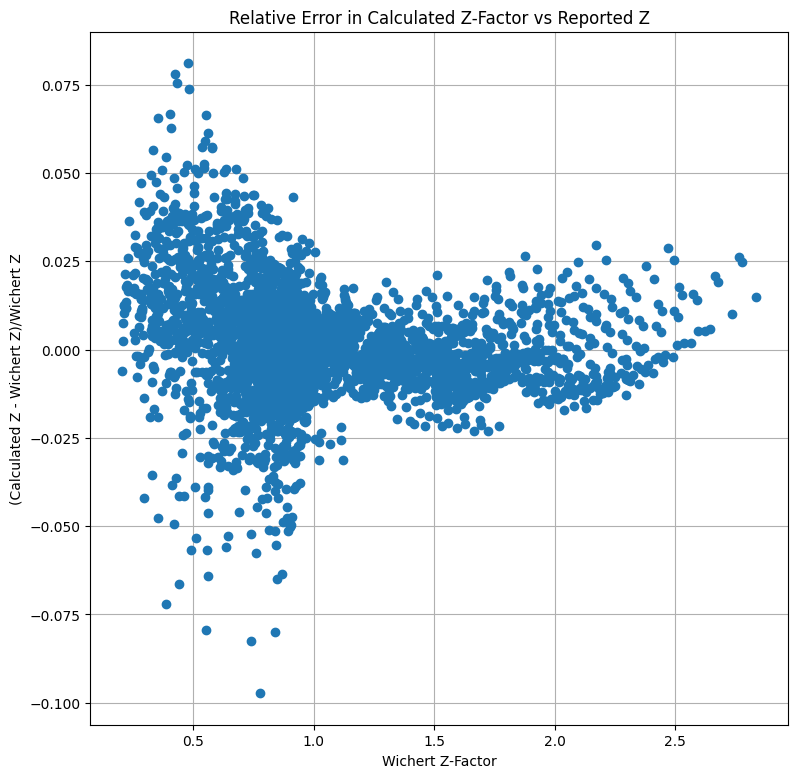

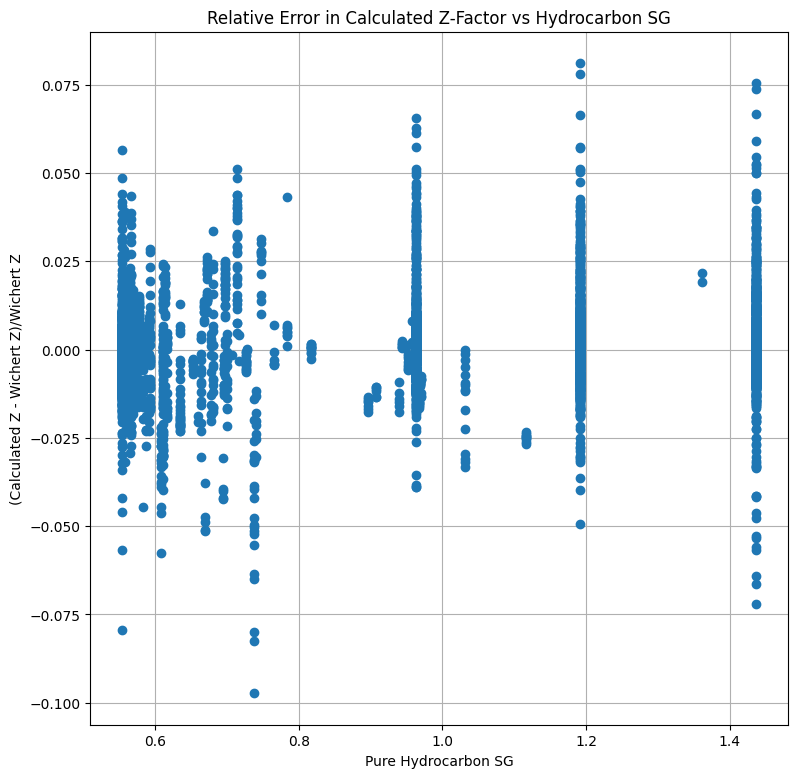

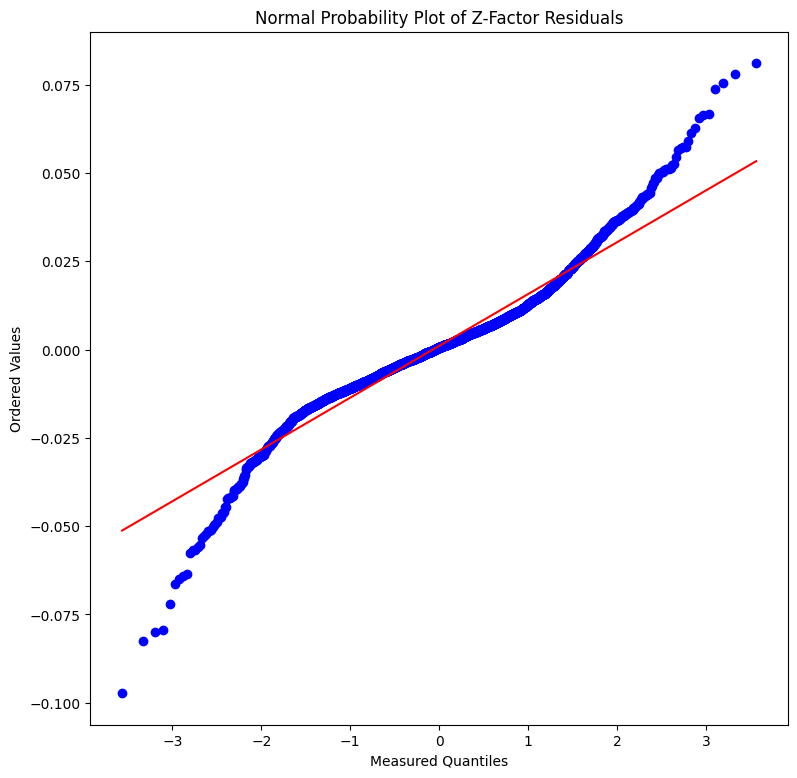

In [10]:
# Compare Wichert data
df = pd.read_excel('Wichert_data_export_v10.xlsx')

degfs = np.array(df['degf'])
psias = np.array(df['psia'])
sgs = np.array(df['sg'])
co2s = np.array(df['co2'])
h2ss = np.array(df['h2s'])
n2s = np.array(df['n2'])
Zs = np.array(df['Z'])

sg_hc = (sgs - (co2s * 44.01 + h2ss * 34.082 + n2s * 28.014) / mwAir) / (1 - co2s - h2ss - n2s)

calc_Zs = []
for i in range(len(degfs)):
    calc_Zs.append(pr_z.peng_robinson_z(degfs[i], psias[i], sgs[i], co2=co2s[i], h2s=h2ss[i], n2=n2s[i]))
calc_Zs = np.array(calc_Zs)

z_dak_pmc = np.array([rtb.gas_z(psias[i], sgs[i], degfs[i], zmethod='DAK', cmethod='PMC', co2 = co2s[i], h2s = h2ss[i], n2 = n2s[i] ) for i in range(len(psias))])
z_dak_sut = np.array([rtb.gas_z(psias[i], sgs[i], degfs[i], zmethod='DAK', cmethod='SUT', co2 = co2s[i], h2s = h2ss[i], n2 = n2s[i] ) for i in range(len(psias))])

plt.plot(Zs, calc_Zs, 'o')
plt.plot([min(Zs), max(Zs)], [min(Zs), max(Zs)], '--', c='k')
plt.title('Wichert Samples Calculated Z-Factor vs Measured')
plt.xlabel('Measured Z-Factor')
plt.ylabel('Calculated Z-Factor')
plt.grid()
plt.savefig('images\\'+'wichert.png')
plt.show()
errs = np.abs(calc_Zs - Zs)/Zs
print('Average Relative error:',np.mean(errs))
print('99% of data better than error:', np.percentile(errs, 99))

errs = (calc_Zs - Zs)/Zs
plt.plot(Zs, errs, 'o')
plt.title('Relative Error in Calculated Z-Factor vs Reported Z')
plt.xlabel('Wichert Z-Factor')
plt.ylabel('(Calculated Z - Wichert Z)/Wichert Z')
plt.grid()
plt.savefig('images\\'+'rel_wichert.png')
plt.show()

plt.plot(sg_hc, errs, 'o')
plt.title('Relative Error in Calculated Z-Factor vs Hydrocarbon SG')
plt.xlabel('Pure Hydrocarbon SG')
plt.ylabel('(Calculated Z - Wichert Z)/Wichert Z')
plt.grid()
plt.savefig('images\\'+'rel_wichert_HC_SG.png')
plt.show()

fig, ax = plt.subplots()
res = stats.probplot(errs, plot=ax)
ax.set_title('Normal Probability Plot of Z-Factor Residuals')
ax.set_xlabel('Measured Quantiles')
ax.set_ylabel('Ordered Values')
plt.savefig('images\\'+'norm_wichert.png')
plt.show()

In [11]:
errs = (calc_Zs - Zs)/Zs
#for i in list(np.where(np.abs(errs)>0.4)[0]):
for i in list(np.where(np.abs(errs)>0.08)[0]):
    print(i, errs[i], calc_Zs[i], Zs[i], degfs[i], psias[i], sgs[i], co2s[i], h2ss[i], n2s[i])

119 -0.097297400200233 0.701399920044419 0.777 81.0 1500.0 0.7416120503969624 0.0061 0.0 0.0
120 -0.0826033245315848 0.6807083331975641 0.742 81.0 2000.0 0.7416120503969624 0.0061 0.0 0.0
2860 0.08112018012388365 0.5176995263612723 0.4788547433292291 90.0 1500.0 1.146385916465309 0.0 0.0 0.2


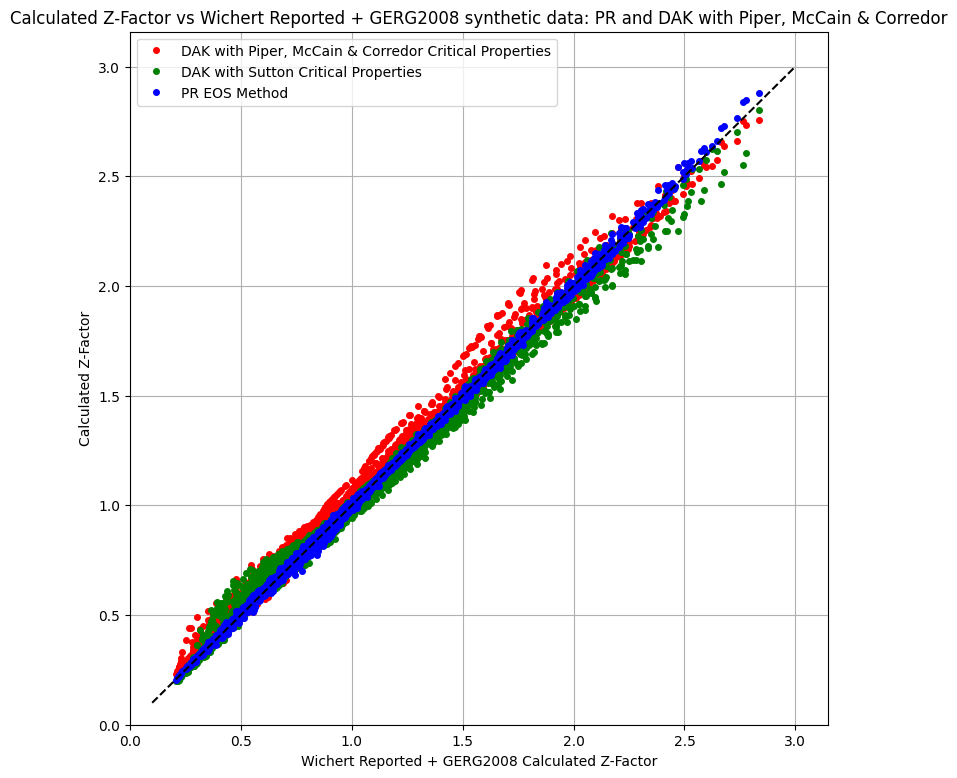

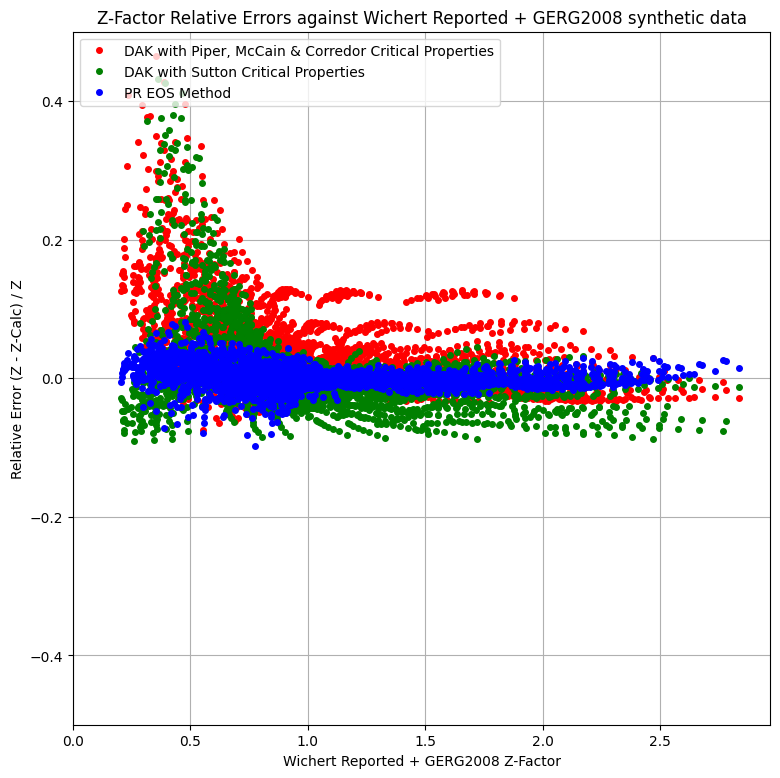

In [12]:
plt.plot(Zs, z_dak_pmc, 'o', c='r', markersize=4, label='DAK with Piper, McCain & Corredor Critical Properties')
plt.plot(Zs, z_dak_sut, 'o', c='g', markersize=4, label='DAK with Sutton Critical Properties')
plt.plot(Zs, calc_Zs, 'o', c='b', markersize=4, label='PR EOS Method')
plt.xlabel('Wichert Reported + GERG2008 Calculated Z-Factor')
plt.ylabel('Calculated Z-Factor')
plt.plot([0.1, 3], [0.1, 3], '--', c='k')
plt.ylim(0, None)
plt.xlim(0, None)
plt.grid()
plt.title('Calculated Z-Factor vs Wichert Reported + GERG2008 synthetic data: PR and DAK with Piper, McCain & Corredor')
plt.legend(loc='upper left')
plt.savefig('images\\'+'Crossplot_Z-PR_DAK_extended.png')
plt.show()

pr_er = (calc_Zs - Zs)/Zs
dak_sut_err = (z_dak_sut - Zs)/Zs
dak_pmc_err = (z_dak_pmc - Zs)/Zs

plt.plot(Zs, dak_pmc_err, 'o', c='r', markersize=4, label='DAK with Piper, McCain & Corredor Critical Properties')
plt.plot(Zs, dak_sut_err, 'o', c='g', markersize=4, label='DAK with Sutton Critical Properties')
plt.plot(Zs, pr_er, 'o', c='b', markersize=4, label='PR EOS Method')
plt.xlabel('Wichert Reported + GERG2008 Z-Factor')
plt.ylabel('Relative Error (Z - Z-Calc) / Z')
#plt.plot([0.1, 3], [0.1, 3], '--', c='k')
plt.ylim(-0.5, 0.5)
plt.xlim(0, None)
plt.grid()
plt.title('Z-Factor Relative Errors against Wichert Reported + GERG2008 synthetic data')
plt.legend(loc='upper left')
plt.savefig('images\\'+'Relative_Errors.png')
plt.show()

In [13]:
pr_er = (calc_Zs - Zs)/Zs
dak_sut_err = (z_dak_sut - Zs)/Zs
dak_pmc_err = (z_dak_pmc - Zs)/Zs

errs = [pr_er, dak_sut_err, dak_pmc_err]
names = ['Peng Robinson', 'DAK + Sutton & Wichert', 'DAK + PMC']
for e, err in enumerate(errs):
    avg = np.mean(err)
    maxerr = max(err)
    print(names[e], 'Avg Rel. Error: '+str(round(avg, 3))+', Max rel. Error: '+str(round(maxerr, 3))+', 95% Errors less than ', str(round(np.percentile(err, 95),4)))

Peng Robinson Avg Rel. Error: 0.001, Max rel. Error: 0.081, 95% Errors less than  0.0272
DAK + Sutton & Wichert Avg Rel. Error: 0.004, Max rel. Error: 0.431, 95% Errors less than  0.0999
DAK + PMC Avg Rel. Error: 0.032, Max rel. Error: 0.654, 95% Errors less than  0.1427


              psia         Z      degf       co2       h2s        n2  \
psia      1.000000  0.882063  0.070513  0.064327  0.014146  0.099802   
Z         0.882063  1.000000  0.084108 -0.056615 -0.224043  0.278984   
degf      0.070513  0.084108  1.000000  0.022525  0.007717  0.049933   
co2       0.064327 -0.056615  0.022525  1.000000 -0.336662 -0.298498   
h2s       0.014146 -0.224043  0.007717 -0.336662  1.000000 -0.330858   
n2        0.099802  0.278984  0.049933 -0.298498 -0.330858  1.000000   
sg_hc     0.190956  0.139926  0.108579  0.099350  0.012180  0.202573   
Residual -0.049381 -0.178901 -0.133550 -0.029618  0.112838  0.006655   

             sg_hc  Residual  
psia      0.190956 -0.049381  
Z         0.139926 -0.178901  
degf      0.108579 -0.133550  
co2       0.099350 -0.029618  
h2s       0.012180  0.112838  
n2        0.202573  0.006655  
sg_hc     1.000000  0.176564  
Residual  0.176564  1.000000  


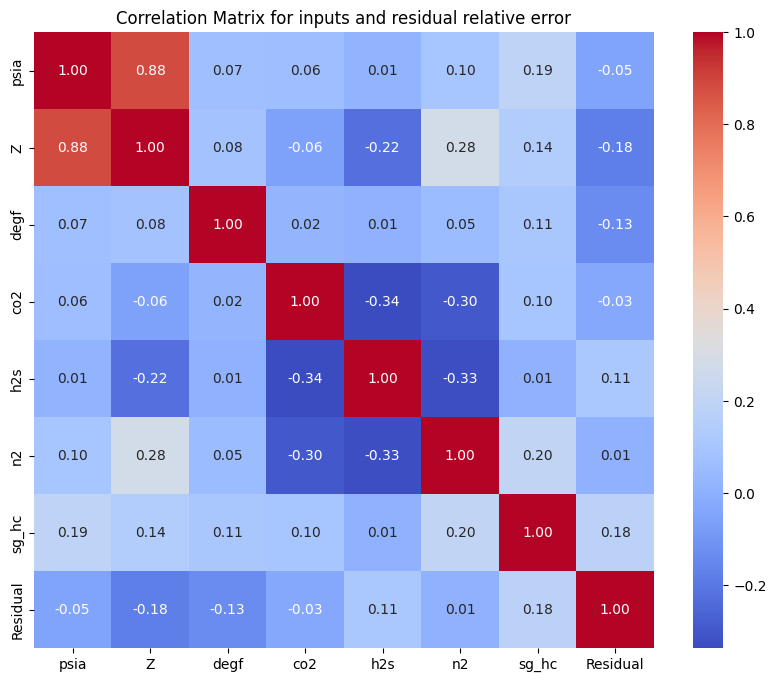

In [14]:
errs = (calc_Zs - Zs)/Zs
df = df[['psia', 'Z', 'degf', 'sg', 'co2', 'h2s', 'n2']].copy()

df['sg_hc'] = (df['sg'] - (df['co2'] * 44.01 + df['h2s'] * 34.082 + df['n2'] * 28.014) / 28.97) / (1 - df['co2'] - df['h2s'] - df['n2'])
df.drop(columns = ['sg'], inplace=True)
df['Residual'] = errs
correlation_matrix = df.corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for inputs and residual relative error')
plt.savefig('images\\'+'corel_wichert.png')
plt.show()

              psia         Z      degf       co2       h2s        n2  \
psia      1.000000  0.882063  0.070513  0.064327  0.014146  0.099802   
Z         0.882063  1.000000  0.084108 -0.056615 -0.224043  0.278984   
degf      0.070513  0.084108  1.000000  0.022525  0.007717  0.049933   
co2       0.064327 -0.056615  0.022525  1.000000 -0.336662 -0.298498   
h2s       0.014146 -0.224043  0.007717 -0.336662  1.000000 -0.330858   
n2        0.099802  0.278984  0.049933 -0.298498 -0.330858  1.000000   
sg_hc     0.190956  0.139926  0.108579  0.099350  0.012180  0.202573   
Residual  0.895732  0.995583  0.080884 -0.059405 -0.177598  0.274390   

             sg_hc  Residual  
psia      0.190956  0.895732  
Z         0.139926  0.995583  
degf      0.108579  0.080884  
co2       0.099350 -0.059405  
h2s       0.012180 -0.177598  
n2        0.202573  0.274390  
sg_hc     1.000000  0.175583  
Residual  0.175583  1.000000  


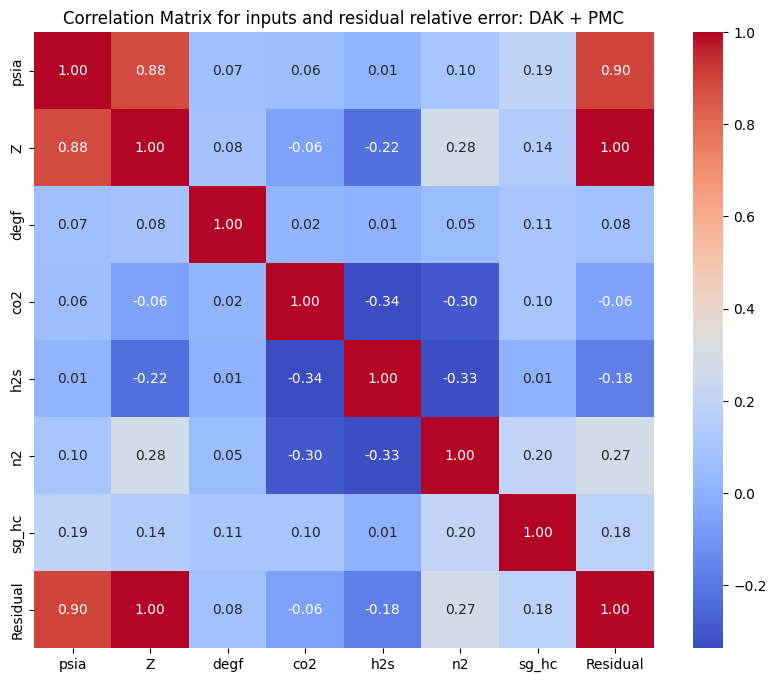

In [15]:
# DAK + PMC
errs = z_dak_pmc
df['Residual'] = errs
correlation_matrix = df.corr()
print(correlation_matrix)


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for inputs and residual relative error: DAK + PMC')
plt.savefig('images\\'+'corel_wichert_DAK_PMC.png')
plt.show()

              psia         Z      degf       co2       h2s        n2  \
psia      1.000000  0.882063  0.070513  0.064327  0.014146  0.099802   
Z         0.882063  1.000000  0.084108 -0.056615 -0.224043  0.278984   
degf      0.070513  0.084108  1.000000  0.022525  0.007717  0.049933   
co2       0.064327 -0.056615  0.022525  1.000000 -0.336662 -0.298498   
h2s       0.014146 -0.224043  0.007717 -0.336662  1.000000 -0.330858   
n2        0.099802  0.278984  0.049933 -0.298498 -0.330858  1.000000   
sg_hc     0.190956  0.139926  0.108579  0.099350  0.012180  0.202573   
Residual  0.880012  0.996364  0.087675 -0.062699 -0.242393  0.288085   

             sg_hc  Residual  
psia      0.190956  0.880012  
Z         0.139926  0.996364  
degf      0.108579  0.087675  
co2       0.099350 -0.062699  
h2s       0.012180 -0.242393  
n2        0.202573  0.288085  
sg_hc     1.000000  0.133024  
Residual  0.133024  1.000000  


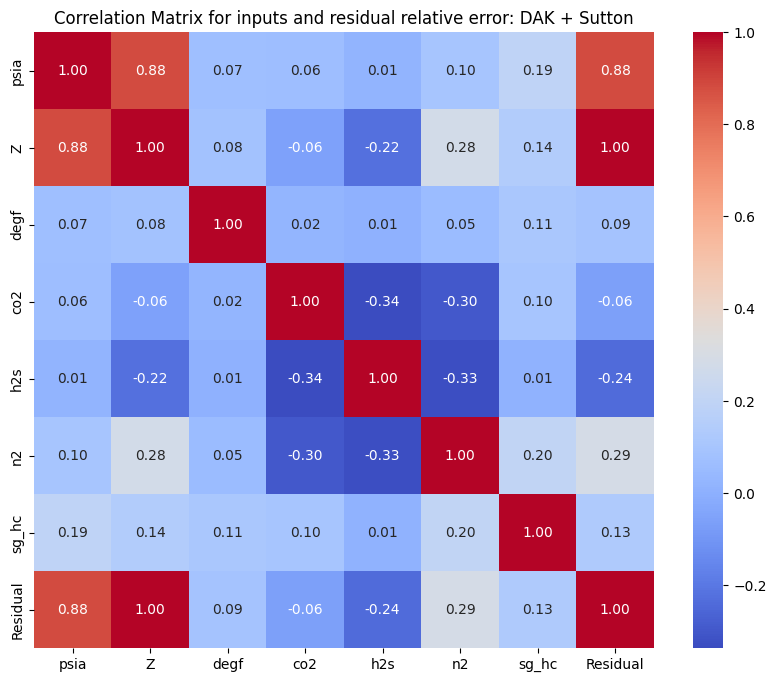

In [16]:
# DAK + Sutton & Wichert
errs = z_dak_sut
df['Residual'] = errs
correlation_matrix = df.corr()
print(correlation_matrix)


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for inputs and residual relative error: DAK + Sutton')
plt.savefig('images\\'+'corel_wichert_DAK_PMC.png')
plt.show()

In [17]:
errs = (calc_Zs - Zs)/Zs
for i in list(np.where(np.abs(errs)>0.15)[0]):
    print(i, errs[i], degfs[i], psias[i], sgs[i], co2s[i], h2ss[i], n2s[i])
    

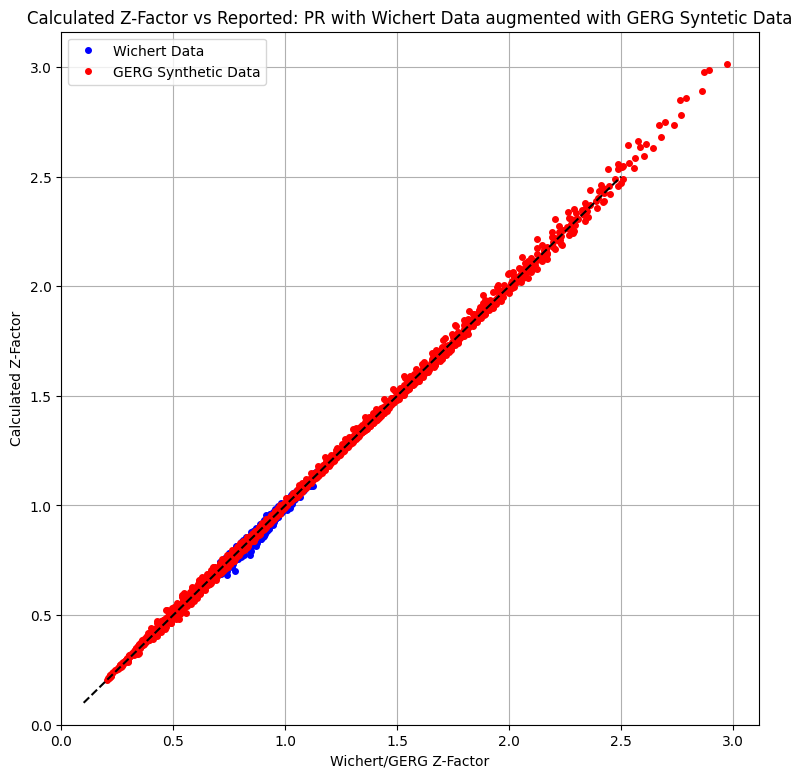

In [18]:
# Compare Wichert & synthetic GERG data
df = pd.read_excel('Wichert_data_export4.xlsx')
filtered = df[df['Source'] == 'Wichert']

degfs = np.array(filtered['degf'])
psias = np.array(filtered['psia'])
sgs = np.array(filtered['sg'])
co2s = np.array(filtered['co2'])
h2ss = np.array(filtered['h2s'])
n2s = np.array(filtered['n2'])
Zs = np.array(filtered['Z'])

calc_Zs = []
for i in range(len(degfs)):
    calc_Zs.append(pr_z.peng_robinson_z(degfs[i], psias[i], sgs[i], co2=co2s[i], h2s=h2ss[i], n2=n2s[i]))
calc_Zs = np.array(calc_Zs)
plt.plot(Zs, calc_Zs, 'o', c='b', markersize=4, label='Wichert Data')

filtered = df[df['Source'] == 'GERG']

degfs = np.array(filtered['degf'])
psias = np.array(filtered['psia'])
sgs = np.array(filtered['sg'])
co2s = np.array(filtered['co2'])
h2ss = np.array(filtered['h2s'])
n2s = np.array(filtered['n2'])
Zs = np.array(filtered['Z'])

calc_Zs = []
for i in range(len(degfs)):
    calc_Zs.append(pr_z.peng_robinson_z(degfs[i], psias[i], sgs[i], co2=co2s[i], h2s=h2ss[i], n2=n2s[i]))
calc_Zs = np.array(calc_Zs)
plt.plot(Zs, calc_Zs, 'o', c='r', markersize=4, label='GERG Synthetic Data')

plt.xlabel('Wichert/GERG Z-Factor')
plt.ylabel('Calculated Z-Factor')
plt.plot([0.1, 2.5], [0.1, 2.5], '--', c='k')
plt.ylim(0, None)
plt.xlim(0, None)
plt.grid()
plt.title('Calculated Z-Factor vs Reported: PR with Wichert Data augmented with GERG Syntetic Data')
plt.legend(loc='upper left')
plt.savefig('images\\'+'Crossplot_Z-PR_GERG&Wichert.png')
plt.show()

# Against 'pure' Wichert data only, contracts PR and GERG2008 Z-Factor predictions
## Note: Wichert data given to C7+ has been extended to C10+ assuming exponential relationship, and C10 properties used for C10+

PR predictions as good, if not slightly better on average

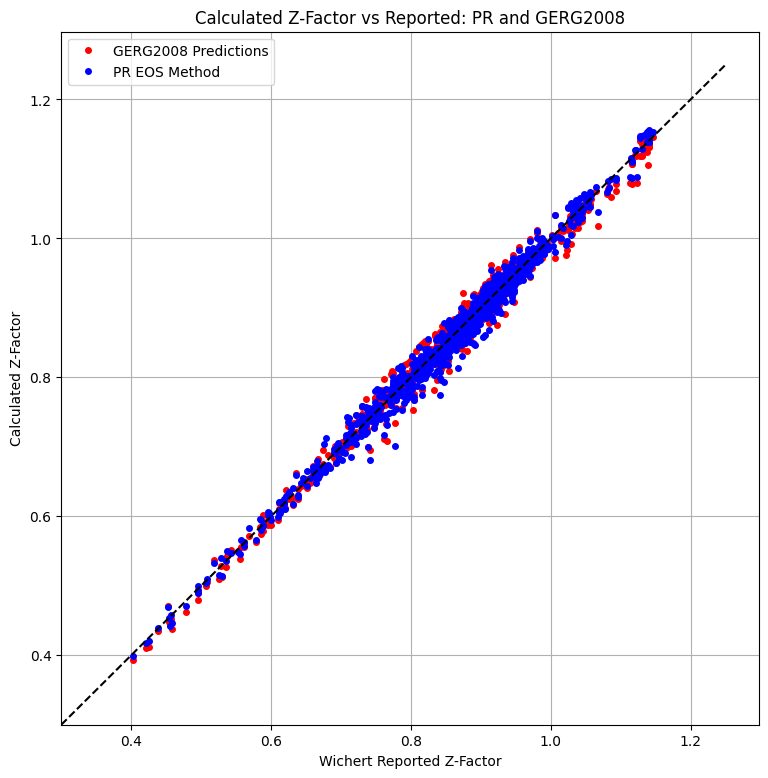

In [19]:
# Compare Wichert data only, including GERG2008 predictions against Wichert mixtures
df = pd.read_excel('Wichert_data_export_v10.xlsx')
filtered = df[df['Source'] == 'Wichert']

degfs = np.array(filtered['degf'])
psias = np.array(filtered['psia'])
sgs = np.array(filtered['sg'])
co2s = np.array(filtered['co2'])
h2ss = np.array(filtered['h2s'])
n2s = np.array(filtered['n2'])
Zs = np.array(filtered['Z'])

c1s = np.array(filtered['C1'])
c2s = np.array(filtered['C2'])
c3s = np.array(filtered['C3'])
ic4s = np.array(filtered['iC4'])
nc4s = np.array(filtered['nC4'])
ic5s = np.array(filtered['iC5'])
nc5s = np.array(filtered['nC5'])
c6s = np.array(filtered['C6'])
c7s = np.array(filtered['C7'])
c8s = np.array(filtered['C8'])
c9s = np.array(filtered['C9'])
c10s = np.array(filtered['C9'])
yis = [np.array([c1s[i], c2s[i], c3s[i], ic4s[i], nc4s[i], ic5s[i], nc5s[i], c6s[i], c7s[7], c8s[i], c9s[i], c10s[i]]) for i in range(len(c1s))]
       
GERG_Zs = []
calc_Zs = []
       
for i in range(len(degfs)):
    calc_Zs.append(pr_z.peng_robinson_z(degfs[i], psias[i], sgs[i], co2=co2s[i], h2s=h2ss[i], n2=n2s[i]))
    GERG_Zs.append(gerg2.gerg_z2(psias[i], degfs[i], yis[i], co2=co2s[i], h2s=h2ss[i], n2=n2s[i], h2 = 0))
calc_Zs = np.array(calc_Zs)

#z_dak_pmc = np.array([rtb.gas_z(psias[i], sgs[i], degfs[i], zmethod='DAK', cmethod='PMC', co2 = co2s[i], h2s = h2ss[i], n2 = n2s[i] ) for i in range(len(psias))])
#z_dak_sut = np.array([rtb.gas_z(psias[i], sgs[i], degfs[i], zmethod='DAK', cmethod='SUT', co2 = co2s[i], h2s = h2ss[i], n2 = n2s[i] ) for i in range(len(psias))])

#plt.plot(Zs, z_dak_pmc, 'o', c='r', markersize=4, label='DAK with Piper, McCain & Corredor Critical Properties')
#plt.plot(Zs, z_dak_sut, 'o', c='g', markersize=4, label='DAK with Sutton Critical Properties')
plt.plot(Zs, GERG_Zs, 'o', c='r', markersize=4, label='GERG2008 Predictions')
plt.plot(Zs, calc_Zs, 'o', c='b', markersize=4, label='PR EOS Method')

plt.xlabel('Wichert Reported Z-Factor')
plt.ylabel('Calculated Z-Factor')
plt.plot([0.3, 1.25], [0.3, 1.25], '--', c='k')
plt.ylim(0.3, None)
plt.xlim(0.3, None)
plt.grid()
plt.title('Calculated Z-Factor vs Reported: PR and GERG2008')

plt.legend(loc='upper left')
plt.savefig('images\\'+'Crossplot_Z-PR_GERG.png')
plt.show()

In [20]:
pr_er = (calc_Zs - Zs)/Zs
GERG_Zs = np.array(GERG_Zs)
gerg_err = (GERG_Zs - Zs)/Zs

errs = [pr_er, gerg_err]
names = ['Peng Robinson', 'GERG2008']
for e, err in enumerate(errs):
    avg = np.mean(err)
    maxerr = max(err)
    print(names[e], 'Avg Rel. Error: '+str(round(avg, 3))+', Max rel. Error: '+str(round(maxerr, 3))+', 95% Errors less than ', str(round(np.percentile(err, 95),4)))

Peng Robinson Avg Rel. Error: -0.003, Max rel. Error: 0.051, 95% Errors less than  0.0234
GERG2008 Avg Rel. Error: 0.001, Max rel. Error: 0.053, 95% Errors less than  0.0288


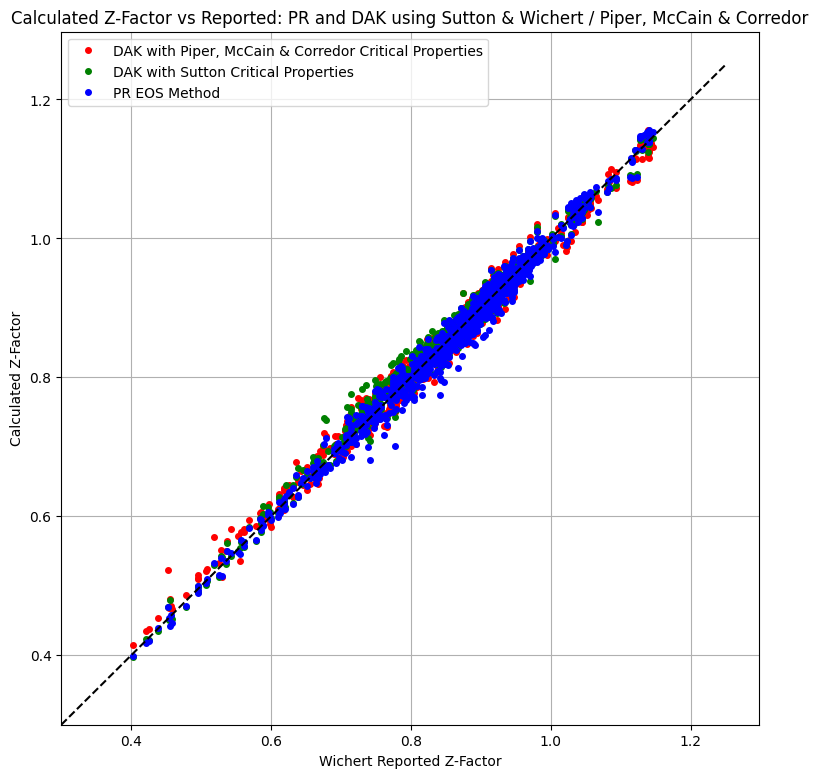

In [21]:
# Compare Wichert data only
df = pd.read_excel('Wichert_data_export_v10.xlsx')
filtered = df[df['Source'] == 'Wichert'].copy()

degfs = np.array(filtered['degf'])
psias = np.array(filtered['psia'])
sgs = np.array(filtered['sg'])
co2s = np.array(filtered['co2'])
h2ss = np.array(filtered['h2s'])
n2s = np.array(filtered['n2'])
Zs = np.array(filtered['Z'])

calc_Zs = []
for i in range(len(degfs)):
    calc_Zs.append(pr_z.peng_robinson_z(degfs[i], psias[i], sgs[i], co2=co2s[i], h2s=h2ss[i], n2=n2s[i]))
z_pr = np.array(calc_Zs)

z_dak_pmc = np.array([rtb.gas_z(psias[i], sgs[i], degfs[i], zmethod='DAK', cmethod='PMC', co2 = co2s[i], h2s = h2ss[i], n2 = n2s[i] ) for i in range(len(psias))])
z_dak_sut = np.array([rtb.gas_z(psias[i], sgs[i], degfs[i], zmethod='DAK', cmethod='SUT', co2 = co2s[i], h2s = h2ss[i], n2 = n2s[i] ) for i in range(len(psias))])



plt.plot(Zs, z_dak_pmc, 'o', c='r', markersize=4, label='DAK with Piper, McCain & Corredor Critical Properties')
plt.plot(Zs, z_dak_sut, 'o', c='g', markersize=4, label='DAK with Sutton Critical Properties')
plt.plot(Zs, z_pr, 'o', c='b', markersize=4, label='PR EOS Method')

plt.xlabel('Wichert Reported Z-Factor')
plt.ylabel('Calculated Z-Factor')
plt.plot([0.3, 1.25], [0.3, 1.25], '--', c='k')
plt.ylim(0.3, None)
plt.xlim(0.3, None)
plt.grid()
plt.title('Calculated Z-Factor vs Reported: PR and DAK using Sutton & Wichert / Piper, McCain & Corredor')

plt.legend(loc='upper left')
plt.savefig('images\\'+'Crossplot_Z-PR_DAK.png')
plt.show()

In [22]:
pr_er = (z_pr - Zs)/Zs
dak_sut_err = (z_dak_sut - Zs)/Zs
dak_pmc_err = (z_dak_pmc - Zs)/Zs

errs = [pr_er, dak_sut_err, dak_pmc_err]
names = ['Peng Robinson', 'DAK + Sutton & Wichert', 'DAK + PMC']
for e, err in enumerate(errs):
    avg = np.mean(err)
    maxerr = max(err)
    print(names[e], 'Avg Rel. Error: '+str(round(avg, 3))+', Max rel. Error: '+str(round(maxerr, 3))+', 95% Errors less than ', str(round(np.percentile(err, 95),4)))

Peng Robinson Avg Rel. Error: -0.003, Max rel. Error: 0.051, 95% Errors less than  0.0234
DAK + Sutton & Wichert Avg Rel. Error: 0.007, Max rel. Error: 0.097, 95% Errors less than  0.0336
DAK + PMC Avg Rel. Error: 0.004, Max rel. Error: 0.157, 95% Errors less than  0.0349


              psia         Z      degf     sg_hc       co2       h2s  \
psia      1.000000  0.292393  0.234101  0.341707 -0.087336  0.014026   
Z         0.292393  1.000000  0.370185  0.220182  0.010425 -0.584901   
degf      0.234101  0.370185  1.000000  0.398276 -0.091556  0.014794   
sg_hc     0.341707  0.220182  0.398276  1.000000 -0.076788 -0.157621   
co2      -0.087336  0.010425 -0.091556 -0.076788  1.000000 -0.196992   
h2s       0.014026 -0.584901  0.014794 -0.157621 -0.196992  1.000000   
n2        0.080536 -0.013262  0.159696  0.333616 -0.073442  0.065775   
Residual  0.335902 -0.041314  0.084378 -0.089990  0.159657 -0.000564   

                n2  Residual  
psia      0.080536  0.335902  
Z        -0.013262 -0.041314  
degf      0.159696  0.084378  
sg_hc     0.333616 -0.089990  
co2      -0.073442  0.159657  
h2s       0.065775 -0.000564  
n2        1.000000  0.060877  
Residual  0.060877  1.000000  


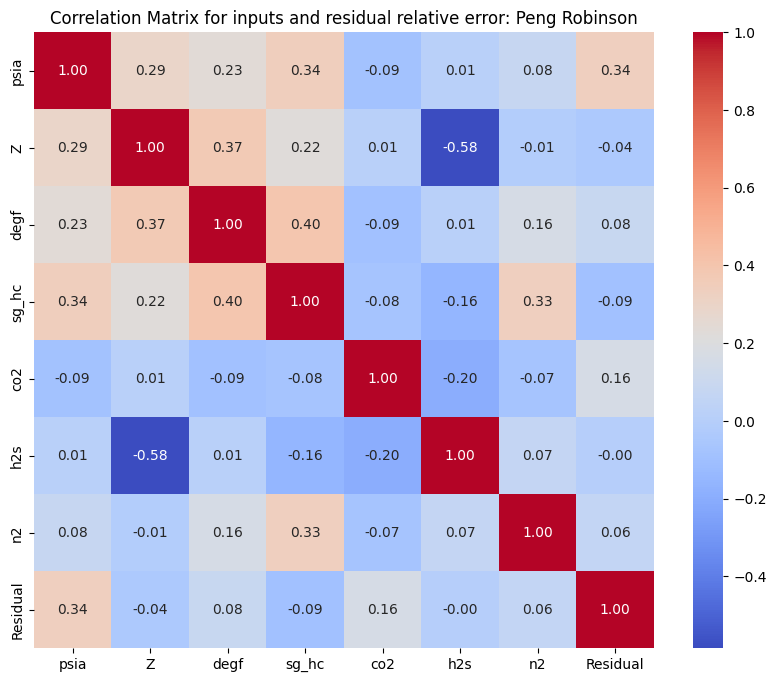

In [23]:
# Peng Robinson
errs = pr_er
filtered['sg_hc'] = (filtered['sg'] - (filtered['co2'] * 44.01 + filtered['h2s'] * 34.082 + filtered['n2'] * 28.014) / 28.97) / (1 - filtered['co2'] - filtered['h2s'] - filtered['n2'])
cor_df = filtered[['psia', 'Z', 'degf', 'sg_hc', 'co2', 'h2s', 'n2']].copy()

cor_df['Residual'] = errs
correlation_matrix = cor_df.corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for inputs and residual relative error: Peng Robinson')
plt.savefig('images\\'+'corel_wichert_PR.png')
plt.show()

              psia         Z      degf     sg_hc       co2       h2s  \
psia      1.000000  0.292393  0.234101  0.341707 -0.087336  0.014026   
Z         0.292393  1.000000  0.370185  0.220182  0.010425 -0.584901   
degf      0.234101  0.370185  1.000000  0.398276 -0.091556  0.014794   
sg_hc     0.341707  0.220182  0.398276  1.000000 -0.076788 -0.157621   
co2      -0.087336  0.010425 -0.091556 -0.076788  1.000000 -0.196992   
h2s       0.014026 -0.584901  0.014794 -0.157621 -0.196992  1.000000   
n2        0.080536 -0.013262  0.159696  0.333616 -0.073442  0.065775   
Residual -0.164524 -0.266585 -0.212475 -0.132556  0.167026 -0.164870   

                n2  Residual  
psia      0.080536 -0.164524  
Z        -0.013262 -0.266585  
degf      0.159696 -0.212475  
sg_hc     0.333616 -0.132556  
co2      -0.073442  0.167026  
h2s       0.065775 -0.164870  
n2        1.000000  0.006051  
Residual  0.006051  1.000000  


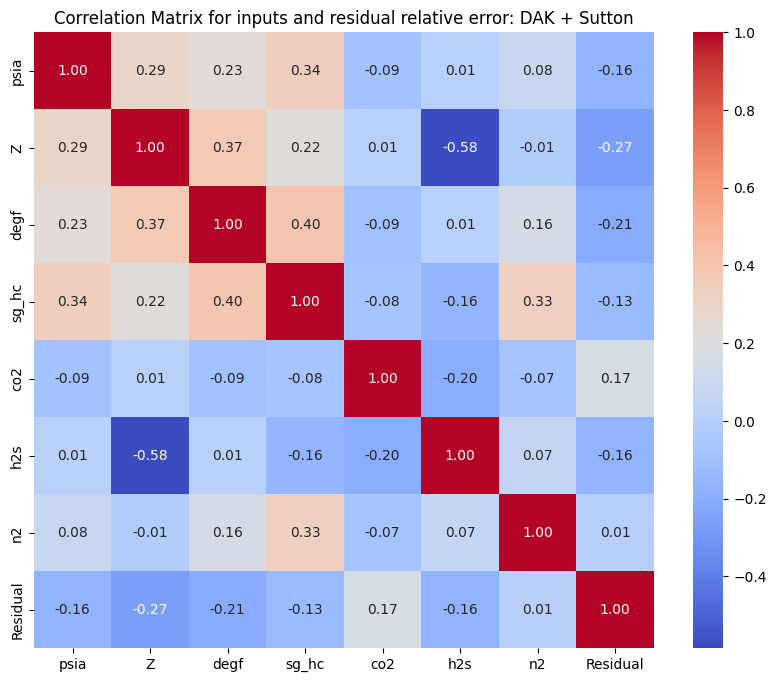

In [24]:
# DAK + Sutton & Wichert
errs = dak_sut_err

cor_df['Residual'] = errs
correlation_matrix = cor_df.corr()
print(correlation_matrix)


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for inputs and residual relative error: DAK + Sutton')
plt.savefig('images\\'+'corel_wichert_DAK_Sutton.png')
plt.show()

              psia         Z      degf     sg_hc       co2       h2s  \
psia      1.000000  0.292393  0.234101  0.341707 -0.087336  0.014026   
Z         0.292393  1.000000  0.370185  0.220182  0.010425 -0.584901   
degf      0.234101  0.370185  1.000000  0.398276 -0.091556  0.014794   
sg_hc     0.341707  0.220182  0.398276  1.000000 -0.076788 -0.157621   
co2      -0.087336  0.010425 -0.091556 -0.076788  1.000000 -0.196992   
h2s       0.014026 -0.584901  0.014794 -0.157621 -0.196992  1.000000   
n2        0.080536 -0.013262  0.159696  0.333616 -0.073442  0.065775   
Residual -0.146988 -0.396748 -0.117471  0.017156 -0.135898  0.192306   

                n2  Residual  
psia      0.080536 -0.146988  
Z        -0.013262 -0.396748  
degf      0.159696 -0.117471  
sg_hc     0.333616  0.017156  
co2      -0.073442 -0.135898  
h2s       0.065775  0.192306  
n2        1.000000  0.181971  
Residual  0.181971  1.000000  


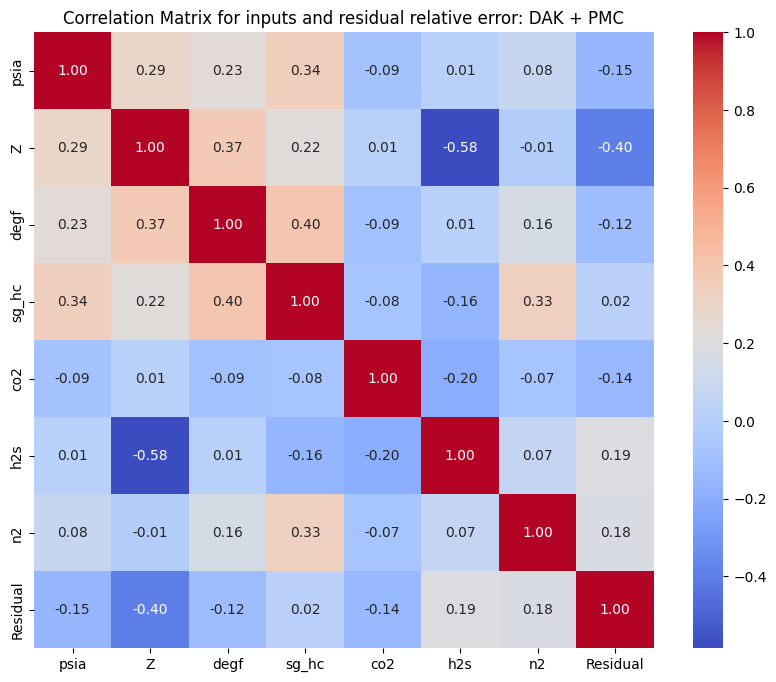

In [25]:
# DAK + PMC
errs = dak_pmc_err

cor_df['Residual'] = errs
correlation_matrix = cor_df.corr()
print(correlation_matrix)


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for inputs and residual relative error: DAK + PMC')
plt.savefig('images\\'+'corel_wichert_DAK_PMC.png')
plt.show()

Text(0.5, 1.0, 'CO2 Fraction Histogram')

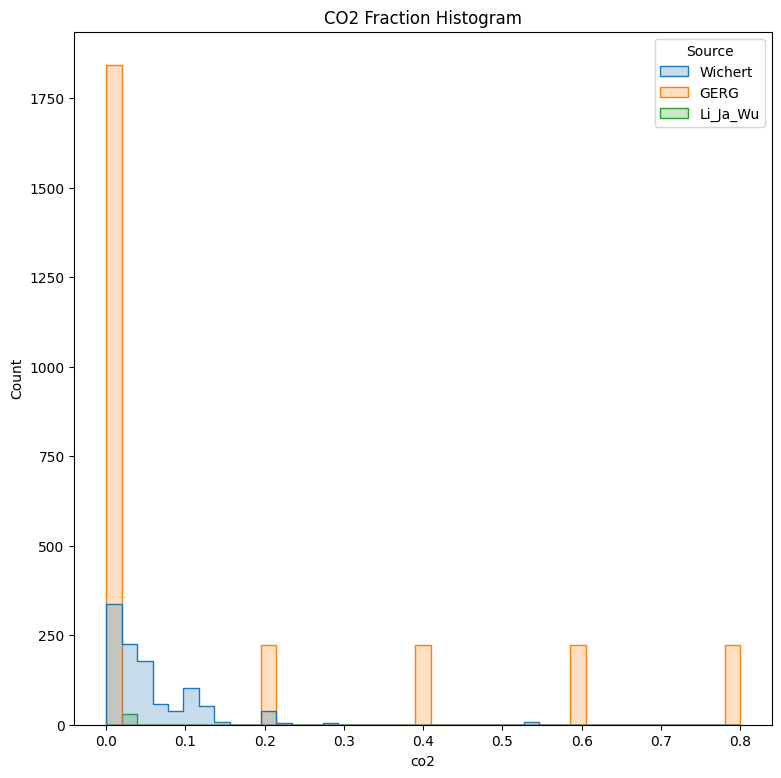

In [26]:
# plot overlapping histograms
sns.histplot(df, x='co2', hue='Source', element="step")
plt.title('CO2 Fraction Histogram')

Text(0.5, 1.0, 'H2S Fraction Histogram')

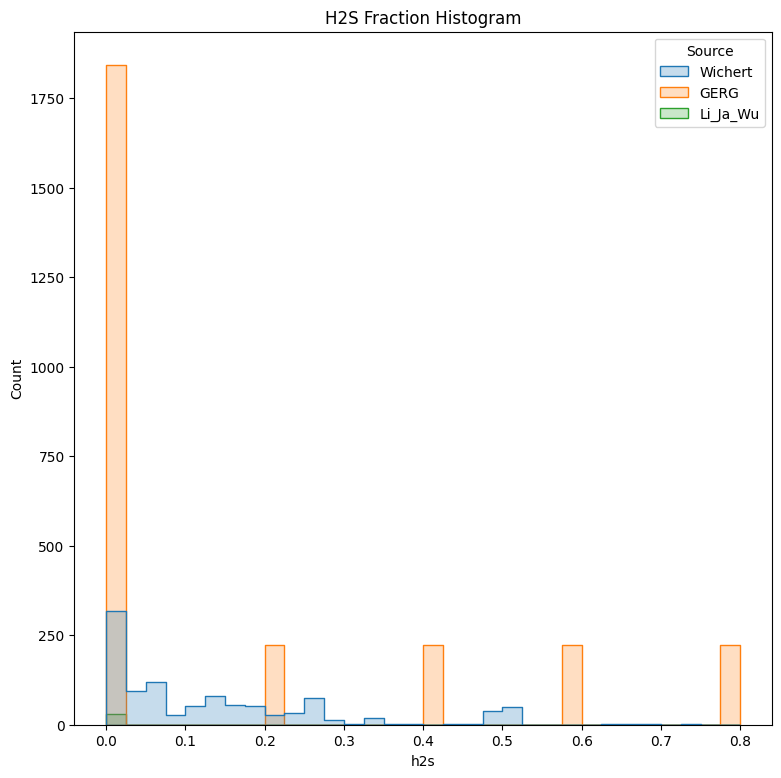

In [27]:
# plot overlapping histograms
sns.histplot(df, x='h2s', hue='Source', element="step")
plt.title('H2S Fraction Histogram')

Text(0.5, 1.0, 'N2 Fraction Histogram')

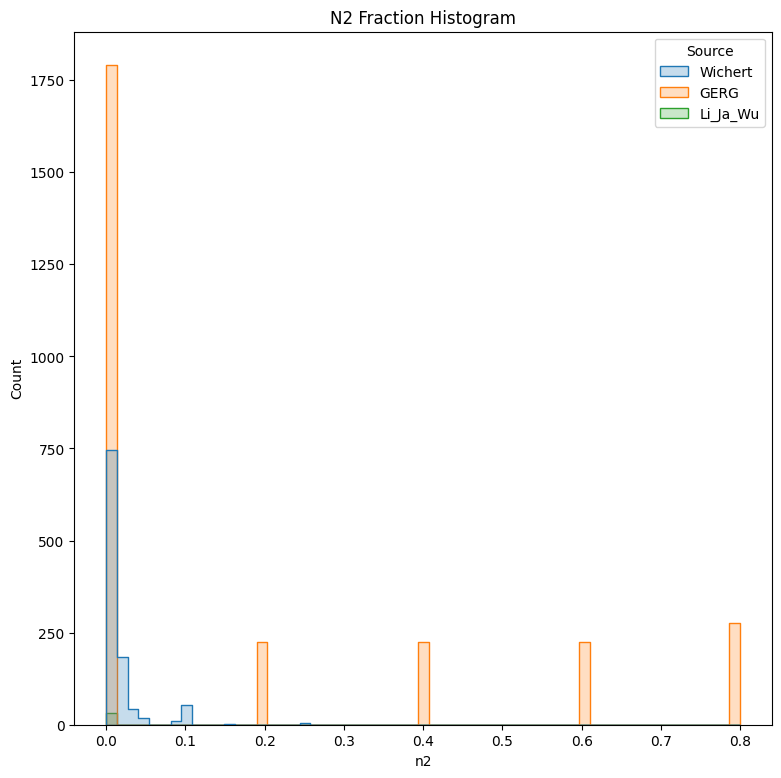

In [28]:
# plot overlapping histograms
sns.histplot(df, x='n2', hue='Source', element="step")
plt.title('N2 Fraction Histogram')

In [29]:
# Read in the interpolated digitized S&K data
df_sk = pd.read_excel('..\\S&K Redigitized by MBurgoyne.xlsx', sheet_name='v2_Interpolated')
trs = np.array(df_sk['Tr'])
prs = np.array(df_sk['Pr'])
sk_zs = np.array(df_sk['Z'])

In [30]:
tc, pc, mw = 343.008, 667.029, 16.043 # Methane
calc_Zs = []
for i in range(len(trs)):
    degf = trs[i]*tc - 459.67
    psia = prs[i] * pc
    calc_Zs.append(pr_z.peng_robinson_z(degf, psia, sg=mw/28.97, co2=0, h2s=0, n2=0, h2=0))

errs = [(sk_zs[i] - calc_Zs[i])/sk_zs[i] for i in range(len(trs))]

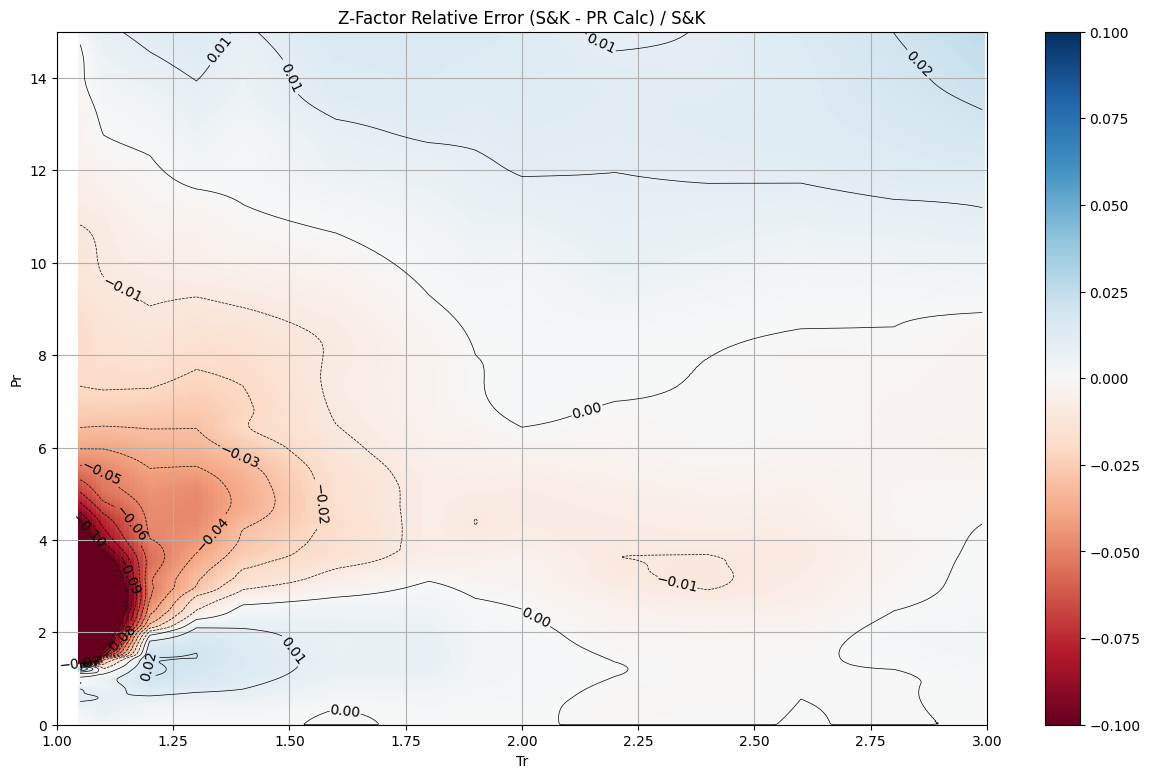

In [31]:
x = trs
y = prs
z = errs
    
# target grid to interpolate to
yi = np.arange(0, 15,0.01)
xi = np.arange(1.05, 3.0, 0.01)
xi,yi = np.meshgrid(xi,yi)

# interpolate
zi = griddata((x,y), z, (xi,yi),method='linear')

rcParams['figure.figsize'] = 15, 9
fig, ax = plt.subplots()
#c = ax.pcolormesh(xi, yi, zi, cmap='RdBu', vmin=zi.min(), vmax=zi.max())
c = ax.pcolormesh(xi, yi, zi, cmap='RdBu', vmin=-0.1, vmax=0.1)
levels = np.arange(-0.1, 0.11, 0.01)
CS = ax.contour(xi, yi, zi, levels=levels, linewidths=0.5, colors='k')
ax.clabel(CS, inline=True, fontsize=10)

ax.set_title('Z-Factor Relative Error (S&K - PR Calc) / S&K')
# set the limits of the plot to the limits of the data
ax.axis([xi.min(), xi.max(), yi.min(), yi.max()])
ax.set_ylabel('Pr')
ax.set_xlabel('Tr')
ax.set_ylim(0, 15)
ax.set_xlim(1.0, 3.0 )
fig.colorbar(c, ax=ax)
plt.grid()
plt.savefig('images\\S&K_Rel_Error_vs_PR.png')
plt.show()

## And contrast with DAK Correlation

In [32]:
tc, pc, mw = 343.008, 667.029, 16.043 # Methane
DAK_calc_Zs = []
for i in range(len(trs)):
    degf = trs[i]*tc - 459.67
    psia = prs[i] * pc
    DAK_calc_Zs.append(rtb.gas_z(psia, 0.75, degf, zmethod='DAK', cmethod='SUT', co2 = 0, h2s = 0, n2 = 0, tc = tc, pc = pc))

errs2 = [(sk_zs[i] - DAK_calc_Zs[i])/sk_zs[i] for i in range(len(trs))]

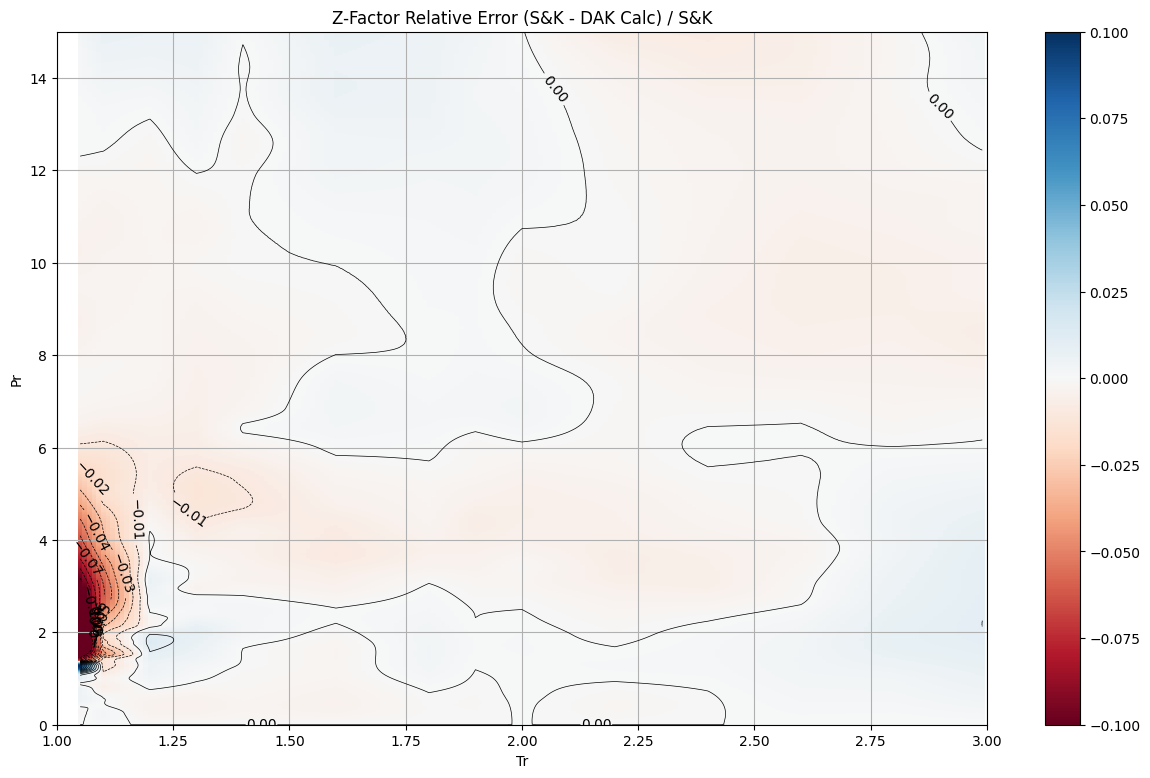

In [33]:
x = trs
y = prs
z = errs2
    
# target grid to interpolate to
yi = np.arange(0, 15,0.01)
xi = np.arange(1.05, 3.0, 0.01)
xi,yi = np.meshgrid(xi,yi)

# interpolate
zi = griddata((x,y), z, (xi,yi),method='linear')

rcParams['figure.figsize'] = 15, 9
fig, ax = plt.subplots()
#c = ax.pcolormesh(xi, yi, zi, cmap='RdBu', vmin=zi.min(), vmax=zi.max())
c = ax.pcolormesh(xi, yi, zi, cmap='RdBu', vmin=-0.1, vmax=0.1)
levels = np.arange(-0.1, 0.11, 0.01)
CS = ax.contour(xi, yi, zi, levels=levels, linewidths=0.5, colors='k')
ax.clabel(CS, inline=True, fontsize=10)

ax.set_title('Z-Factor Relative Error (S&K - DAK Calc) / S&K')
# set the limits of the plot to the limits of the data
ax.axis([xi.min(), xi.max(), yi.min(), yi.max()])
ax.set_ylabel('Pr')
ax.set_xlabel('Tr')
ax.set_ylim(0, 15)
ax.set_xlim(1.0, 3.0 )
fig.colorbar(c, ax=ax)
plt.grid()
plt.savefig('images\\S&K_Rel_Error_vs_DAK.png')
plt.show()

In [34]:
def lee_kesler_tc_pc(xi, co2, h2s, n2): # From SPE Monograph, pp 91/240
    components = ['CO2', 'H2S', 'N2', 'C1', 'C2', 'C3', 'I-C4', 'N-C4', 'I-C5', 'N-C5', 'N-C6', 'N-C7', 'N-C8', 'N-C9', 'N-C10']
    MW = np.array([44.01, 34.082, 28.014, 16.043, 30.07, 44.097, 58.123, 58.123, 72.15, 72.15, 86.177, 100.204, 114.231, 128.258, 142.285])
    Tc = np.array([547.416, 672.12, 227.16, 343.008, 549.576, 665.694, 734.13, 765.216, 828.702, 845.46, 913.68, 972.36, 1023.66, 1070.28, 1111.86])
    Pc = np.array([1069.508, 1299.973, 492.838, 667.029, 706.624, 616.12, 527.937, 550.563, 490.373, 488.777, 438.739, 397.403, 361.144, 332.136, 306.03])
    ACF = np.array([0.225, 0.09, 0.037, 0.011, 0.099, 0.152, 0.186, 0.2, 0.229, 0.252, 0.3, 0.35, 0.399, 0.445, 0.49])
    VC = np.array([1.50686, 1.56981, 1.44326, 1.57942, 2.33069, 3.20369, 4.20805, 4.08471, 4.93849, 4.98174, 5.89479, 6.8559, 7.88108, 8.89025, 9.99552])

    xi =np.array(xi)/np.sum(xi)
    xi = xi*(1-co2-h2s-n2)
    z = np.array([co2, h2s, n2]+list(xi))

    Vcl = 0
    for i in range(len(MW)):
        for j in range(len(MW)):
            Vcl += 1/8 * z[i]*z[j]*(VC[i]**(1/3) + VC[j]**(1/3))**3
    Tcl = 0
    for i in range(len(MW)):
        for j in range(len(MW)):
            Tcl += 1/(8*Vcl) * z[i]*z[j]*(Tc[i]*Tc[j])**(1/2)*(VC[i]**(1/3) + VC[j]**(1/3))**3

    wl = np.sum(z*ACF)
    Zcl = 0.2905 - 0.085*wl
    Pcl = Zcl * R * Tcl / Vcl
    return Tcl, Pcl
    


In [35]:
lee_kesler_tc_pc([0.571885113, 0.087644452, 0.069725338, 0.027734914, 0.027734914, 0.022064446, 0.022064446, 0.035106636, 0.027929002, 0.022218852, 0.017676155, 0.068215732], 0, 0, 0)

(608.7178981327803, 623.4933424017122)